# Praca magisterska

### Tworzenie środowiska

Tworzenie środowiska *mgr* korzystając z instrukcji https://www.tensorflow.org/install/pip?hl=pl#windows-native .

In [456]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Import bibliotek

In [457]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Zbiór danych

Pochodzi z platformy Kaggle: https://www.kaggle.com/datasets/datasnaek/mbti-type .

In [458]:
#każdy rząd składa się z typu osobowości i 50 ostatnich postów
df = pd.read_csv('mbti_1.csv', sep=',')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [459]:
df.shape

(8675, 2)

Zbiór alternatywny, dodatkowy pochodzi z platformy Zenodo: https://zenodo.org/records/1482951

In [460]:
#posty z Reddita (źródło dodatkowe) - wersja zbioru danych 0.1.0
#minus - brak kontekstów, konieczny preprocessing tagów
#plus - potężna baza danych

#rząd zawiera flair_text (flair sam w sobie to tag do oznaczania postów), w tym przypadku flair autora posta, którym oznaczył się w danym subreddicie, 
#   https://support.reddithelp.com/hc/en-us/articles/205242695-How-do-I-get-user-flair-
#   uwaga - niektóre subreddity pozwalają na dopisanie znaków do tagu danego użytkownika
#tekst komentarza (posta?), 
#nazwę subreddita (grupy tematycznej na Reddicie) 
#oraz nazwę autora

df2 = pd.read_csv('full_pull_v2000000000000.csv', sep=',')
df2.head(15)

,flair_text,body,subreddit,author
0,INFP: The Dreamer Senpai,Lol that's why I left.,entp,LadyBanterbury
1,INTP: The Theorist,"I was just about to post ""I try telling people...",INTP,Finarin
2,INFP: The Dreamer,My first thought was Pepsi or something. Proba...,WTF,xanplease
3,"ENTP: Antisocial Extrovert, Rational Eccentric","Not if the formula is something like ""every ti...",youtubehaiku,HeirToGallifrey
4,INTP/18/m/blankly staring at you,Does this imply I'm a five now?,entp,lightfive
5,INTP: The Theorist,"Well, I wouldn't know but I think there's a lo...",InternetIsBeautiful,ElementalVoltage
6,The INFJ Dude,"sine na, support the directors, actors and oth...",Philippines,BabyFlo70
7,Honorary INFP; INTP/21/F,I use just enough vacation days so that I don'...,tumblr,RockinSocksReborn
8,intp or something of the sort,Can be ur angle... or you're devil ;),woof_irl,crowbird_
9,INTP/23/F,I mean we don't how much influence Crow has on...,RWBY,RockinSocksReborn


In [461]:
df2.shape

(1555110, 4)

In [462]:
#próba filtrowania zbioru dodatkowego używając popularnych tagów - uwaga, dostępne tagi użytkownika zależą od subreddita

print(df2.flair_text.str.contains('INFP: The Dreamer').sum()) 
print(df2.flair_text.str.contains('INFP: The Humanist').sum())  #niestety istnieją różne konwencje nazewnictwa
print(df2.flair_text.str.contains('INTP: The Theorist').sum()) 

136677
0
41653


In [463]:
#poszukiwanie częstej i jasnej konwencji dla typu ESTJ
#[ESFJ | previously mistyped ESTJ | 2w3]    - myląca flaga w kontekście klasyfikacji
#ESTJ 3w4   - również znany sposób oznaczania

d = df2[df2.flair_text.str.contains('ESTJ')]
d.iloc[:, :2].groupby('flair_text').count().sort_values(by='body', ascending=False)

,body
flair_text,
[ESTJ],1727
ESTJ♂,623
ESTJ: The Supervisor,561
ESTJ 3,442
ESTJ 3w4,377
ESTJ dX/dY,358
ESTJ 0w10,343
ESTJ 0w9,336
[ESTJ] 3,328


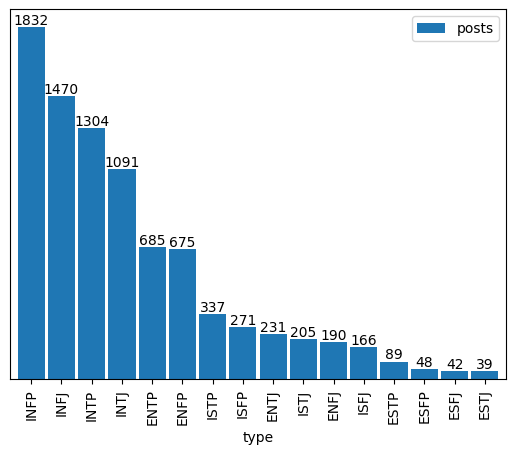

In [464]:
#podstawowy zbiór danych - dystrybucja postów między typami

ax = df.groupby('type').count().sort_values(by='posts', ascending=False).plot.bar(width=0.9)
ax.bar_label(ax.containers[0])[1]
ax.yaxis.set_visible(False)

In [465]:
#poszukiwanie częstej i jasnej konwencji dla wszystkich typów (na późniejsze potrzeby dopełniania podstawowego zbioru do 3 500 postów na typ)

# d2 = df2[df2.flair_text.str.contains('ESTJ')]
# d2.iloc[:, :2].groupby('flair_text').count().sort_values(by='body', ascending=False)

In [466]:
#przygotowane tagi zestawu uzupełniającego:

#typy nie potrzebujące uzupełnienia
tags1 = {'INFP: The Dreamer': 'INFP',   #135635
         '[INFJ]': 'INFJ', 'INFJ: The Protector':'INFJ', 'INFJ: The Visionary':'INFJ',   #25459, 10357, 5022
         '[INTP]': 'INTP', 'INTP: The Theorist': 'INTP',  #78885, 41503
         '[INTJ]': 'INTJ'   #60873
}

#typy potrzebujące uzupełnienia
tags2 = {'[ENTP]': 'ENTP', 'ENTP: The Explorer': 'ENTP',  #41196, 15270
         '[ENFP]': 'ENFP', 'ENFP: The Advocate': 'ENFP',  #16494, 11508
         '[ISTP]': 'ISTP', 'ISTP: The Analyzer': 'ISTP',  #17911, 4903
         '[ISFP]': 'ISFP', 'ISFP: The Artist': 'ISFP',  #3891, 1902
         '[ENTJ]': 'ENTJ', 'ENTJ: The Strategist': 'ENTJ',  #8465, 3832
         '[ISTJ]': 'ISTJ',   #5192
         'ENFJ: The Giver': 'ENFJ', '[ENFJ]': 'ENFJ',  #15315, 4817
         '[ISFJ]': 'ISFJ', 'ISFJ - Male': 'ISFJ', 'ISFJ - Female': 'ISFJ',  #3726, 2266, 1253
         '[ESTP]': 'ESTP',  #7276
         '[ESFP]': 'ESFP', 'ESFP: The Presenter': 'ESFP',  #1513, 749
         '[ESFJ]': 'ESFJ', 'ESFJ - The Gossiper	': 'ESFJ', 'ESFJ: The Facilitator': 'ESFJ',  #1512, 89, 52
         '[ESTJ]': 'ESTJ', 'ESTJ: The Supervisor': 'ESTJ' #1727, 561
}

### Mały i zbalansowany zbiór

Rozpoczniemy od stworzenia małego zbalansowanego zbioru danych (używając zbioru podstawowego). W tym celu wylosujemy identyczną ilość próbek z każdej z 16 klas (stratified random sampling). 

In [467]:
#16 typów osobowości - nazwy klas
types = df.type.unique().tolist()
print(types)

#dodanie kolumny z klasami wyrażonymi liczbami (0 - 15)
df['class_no'] = df.apply(lambda x: types.index(x['type']), axis=1)

df

['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP', 'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']


,type,posts,class_no
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,2
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",3
4,ENTJ,'You're fired.|||That's another silly misconce...,4
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,8
8671,ENFP,'So...if this thread already exists someplace ...,7
8672,INTP,'So many questions when i do these things. I ...,2
8673,INFP,'I am very conflicted right now when it comes ...,6


In [468]:
idx_to_type = {}

for i, t in enumerate(types):
    idx_to_type[i] = t

idx_to_type

{0: 'INFJ',
 1: 'ENTP',
 2: 'INTP',
 3: 'INTJ',
 4: 'ENTJ',
 5: 'ENFJ',
 6: 'INFP',
 7: 'ENFP',
 8: 'ISFP',
 9: 'ISTP',
 10: 'ISFJ',
 11: 'ISTJ',
 12: 'ESTP',
 13: 'ESFP',
 14: 'ESTJ',
 15: 'ESFJ'}

In [469]:
#zamiana separatora postów na inny, łatwo rozróżnialny
df['posts_list'] = df['posts'].str.replace(pat = '|||', repl = ' ||| ')

#zamiana stringów na listy postów
df['posts_list'] = df['posts_list'].str.split(pat = ' ||| ', regex=False)


In [470]:
#dodanie kolumny z długościami list
df['len_posts'] = df['posts_list'].str.len()

In [471]:
#niektóre rzędy posiadają mniej niż 50 postów
df[df.len_posts < 50].shape

(991, 5)

In [472]:
#usuwamy rzędy zawierające mniej niż 50 postów
df = df[df.len_posts == 50]

#usuwanie kolumny z ilościami postów
df = df.drop(columns = ['len_posts'])

In [473]:
df[['type', 'posts']].groupby('type').count().sort_values(by='posts', ascending=False)#.plot.bar(width=0.9)
# ax.bar_label(ax.containers[0])[1]
# ax.yaxis.set_visible(False)

,posts
type,
INFP,1636
INFJ,1305
INTP,1149
INTJ,934
ENTP,592
ENFP,572
ISTP,302
ISFP,226
ENTJ,206


In [474]:
#najmniej postów jest dostępnych dla typu ESTJ (35)
#wybierzmy po 30 próbek z każdego typu (po 1500 postów)

random.seed(123)

df_equal = pd.DataFrame()
for t in types:
    df_type = df[df.type == t]
    df_type = df_type.loc[random.sample(df_type.index.to_list(), 30)]
    print(df_type.index)  #zawsze te same indeksy z powodu seeda
    df_equal = pd.concat([df_equal, df_type])
df_equal.shape #16 * 30

Index([ 719, 3512, 1298, 5395, 3507, 1522,  518, 5052, 7322, 7682, 4436, 4546,
        715, 2295, 1958, 4481, 7663, 4447, 3323, 2406,   10, 5863, 1299, 8134,
       5042, 1002,   68, 4264, 6025, 1445],
      dtype='int64')
Index([ 705, 1515, 2193, 1913,  395, 4301, 6282, 8639, 7124, 3919, 6945,  647,
       4522, 5117, 7768, 7186, 2872, 7855, 8512, 4665,  241, 5787, 7659, 6343,
       8135, 7221, 7766, 6134, 5537, 7638],
      dtype='int64')
Index([ 433, 2951, 1377, 7584, 4198, 2678, 5295, 5331, 8571, 6138, 1180, 7114,
       6104, 5306,  199, 3094, 1483, 5744,  173, 5550, 3697, 6340, 8251, 7756,
        859, 4579, 7685, 3749, 8435, 7525],
      dtype='int64')
Index([1696, 1506, 5136, 4323, 3519, 7152, 4588,  376,   78, 1190, 4514, 1779,
        196, 2362, 7592, 3246, 6488, 2475, 4160, 6047, 3996,    3,  957, 5880,
        522, 4940, 3297, 6711,  756,  712],
      dtype='int64')
Index([5016,   24, 8427, 6018, 4460,  799, 6052, 7435, 6978, 4752,  284, 3908,
       3265, 5237,  288, 6158

(480, 4)

### Podział danych

Ważne, aby posty jednej osoby nie znalazły się zarówno w zbiorze testowym jak i treningowym. Wybrana relacja train/test: 25/5.

In [475]:
random.seed(10)

df_test = pd.DataFrame()
df_train = pd.DataFrame()

for t in types:
    df_type = df_equal[df_equal.type == t]

    test_indexes = random.sample(df_type.index.to_list(), 5)
    print(test_indexes)      #zawsze te same indeksy z powodu seeda
    df_type_test = df_type.loc[test_indexes]
    df_type_train = df_type[~df_type.index.isin(test_indexes)]

    df_test = pd.concat([df_test, df_type_test])
    df_train = pd.concat([df_train, df_type_train])

df_test.shape, df_train.shape

[3323, 3512, 2295, 4481, 719]
[6282, 7768, 7766, 7186, 7124]
[3697, 4579, 2678, 2951, 1483]
[3246, 4514, 5136, 376, 5880]
[3908, 24, 5237, 4423, 4460]
[786, 1679, 7168, 4208, 8381]
[2012, 2847, 1015, 3706, 1331]
[3826, 8429, 8341, 1365, 7789]
[1906, 3955, 3873, 2103, 731]
[8439, 3524, 8301, 1576, 8628]
[7351, 947, 2923, 4920, 4861]
[7137, 4016, 5607, 8632, 8523]
[113, 6759, 447, 3009, 3052]
[2008, 7804, 7366, 1218, 5579]
[8003, 7480, 5660, 2694, 7252]
[6710, 2431, 4277, 3495, 7403]


((80, 4), (400, 4))

In [476]:
df_test.index

Index([3323, 3512, 2295, 4481,  719, 6282, 7768, 7766, 7186, 7124, 3697, 4579,
       2678, 2951, 1483, 3246, 4514, 5136,  376, 5880, 3908,   24, 5237, 4423,
       4460,  786, 1679, 7168, 4208, 8381, 2012, 2847, 1015, 3706, 1331, 3826,
       8429, 8341, 1365, 7789, 1906, 3955, 3873, 2103,  731, 8439, 3524, 8301,
       1576, 8628, 7351,  947, 2923, 4920, 4861, 7137, 4016, 5607, 8632, 8523,
        113, 6759,  447, 3009, 3052, 2008, 7804, 7366, 1218, 5579, 8003, 7480,
       5660, 2694, 7252, 6710, 2431, 4277, 3495, 7403],
      dtype='int64')

### Rozpakowanie postów

Każda z 480 próbek zawiera wewnątrz 50 postów. Należy traktować je oddzielnie.

In [477]:
#rozpakowanie list do osobnych rzędów
df_test = df_test.explode('posts_list')
df_train = df_train.explode('posts_list')

df_test.shape, df_train.shape

((4000, 4), (20000, 4))

In [478]:
df_test

,type,posts,class_no,posts_list
3323,INFJ,"'ENFJ imo, out of the ones you narrowed it dow...",0,"'ENFJ imo, out of the ones you narrowed it dow..."
3323,INFJ,"'ENFJ imo, out of the ones you narrowed it dow...",0,So who's ready for a 4-1-7 description??? ;)
3323,INFJ,"'ENFJ imo, out of the ones you narrowed it dow...",0,"I'm thinking ISTJ, which is why her feelings c..."
3323,INFJ,"'ENFJ imo, out of the ones you narrowed it dow...",0,"i came here because I was thinking about this,..."
3323,INFJ,"'ENFJ imo, out of the ones you narrowed it dow...",0,Definitely legit. i love this author's work an...
...,...,...,...,...
7403,ESFJ,'About to shower and then make grilled cheese....,15,I'll probably be pretty good at feeding it. :t...
7403,ESFJ,'About to shower and then make grilled cheese....,15,"If I didn't know better, I'd say you were my I..."
7403,ESFJ,'About to shower and then make grilled cheese....,15,Feeling relieved. Talking things out didn't en...
7403,ESFJ,'About to shower and then make grilled cheese....,15,My INFP roommate knows she can tell me anythin...


In [479]:
#usunięcie zbiorczej kolumny
df_test = df_test.drop(columns = ['posts'])
df_train = df_train.drop(columns = ['posts'])

#zmiana nazwy kolumny
df_test = df_test.rename(columns = {'posts_list':'post'})
df_train = df_train.rename(columns = {'posts_list':'post'})

In [480]:
df_test.dtypes

type        object
class_no     int64
post        object
dtype: object

In [481]:
#zmiana typów zmiennych
df_test = df_test.astype({'type':'string', 'post':'string'})
df_train = df_train.astype({'type':'string', 'post':'string'})

In [482]:
df_test.shape, df_train.shape   # 5 rzędów * 16 osobowości * 50 postów, 25 rzędów * 16 osobowości * 50 postów

((4000, 3), (20000, 3))

In [483]:
df_test.head()

,type,class_no,post
3323,INFJ,0,"'ENFJ imo, out of the ones you narrowed it dow..."
3323,INFJ,0,So who's ready for a 4-1-7 description??? ;)
3323,INFJ,0,"I'm thinking ISTJ, which is why her feelings c..."
3323,INFJ,0,"i came here because I was thinking about this,..."
3323,INFJ,0,Definitely legit. i love this author's work an...


### Czyszczenie tekstu i ekstrakcja cech

Tokenizacja

In [484]:
#zmiejszenie liter i rozdzielenie ciągów znaków na listy słów/cząstek
# df_test['post_words'] = df_test.apply(lambda x: word_tokenize(x['post'].lower()), axis=1)
# df_train['post_words'] = df_train.apply(lambda x: word_tokenize(x['post'].lower()), axis=1)

#zmiejszenie liter i rozdzielenie ciągów znaków na listy słów/cząstek - ten tokenizer nie rozdziela na "he" + "'s" i zachowuje całe emotki oraz hashtagi
tweet_tokenizer = TweetTokenizer()
df_test['post_words'] = df_test.apply(lambda x: tweet_tokenizer.tokenize(x['post'].lower()), axis=1)
df_train['post_words'] = df_train.apply(lambda x: tweet_tokenizer.tokenize(x['post'].lower()), axis=1)

In [485]:
print(df_test.index) #problem powtarzalnych indeksów

#naprawa - unikalne indeksy
df_test = df_test.reset_index()
df_train = df_train.reset_index()

print(df_test.index)

Index([3323, 3323, 3323, 3323, 3323, 3323, 3323, 3323, 3323, 3323,
       ...
       7403, 7403, 7403, 7403, 7403, 7403, 7403, 7403, 7403, 7403],
      dtype='int64', length=4000)
RangeIndex(start=0, stop=4000, step=1)


Słowa bez znaczenia

In [486]:
#usuwanie słów bez znaczenia ('stopwords')
nltk.download('stopwords')

#wszystkie są pisane małymi literami
#uwaga - usunięte będą zarówno słowa "have/has" jak i skrócone wersje "i've/he's" - jeśli typy osobowości znajdują rozróżnienie na tym polu to badanie będzie ograniczone
stopwords.words('english')[:15], stopwords.words('english')[-15:]

#co istotne - zbiór zawiera zarówno wersje słów "w całości" jak i "w częściach" (dowolność tokenizacji): ‘won’, ‘t’, “won’t”
#nie zawiera cząstek, które otrzymamy używając word_tokenize biblioteki NLTK - "'s"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours'],
 ["mustn't",
  'needn',
  "needn't",
  'shan',
  "shan't",
  'shouldn',
  "shouldn't",
  'wasn',
  "wasn't",
  'weren',
  "weren't",
  'won',
  "won't",
  'wouldn',
  "wouldn't"])

In [487]:
#jednoliterowe słowa bez znaczenia
for word in stopwords.words('english'):
    if len(word) == 1:
        print(word)

i
a
s
t
d
m
o
y


In [488]:
stop_set = set(stopwords.words('english'))

#problem
"i'm" in stop_set, "i've" in stop_set, "i" in stop_set, "have" in stop_set, "am" in stop_set, "im" in stop_set, "m" in stop_set, "'m" in stop_set
#należy rozdzielić słowa z uwzględnieniem apostrofów

(False, False, True, True, True, False, True, False)

In [489]:
df_test.post_words

0       [', enfj, imo, ,, out, of, the, ones, you, nar...
1       [so, who's, ready, for, a, 4-1-, 7, descriptio...
2       [i'm, thinking, istj, ,, which, is, why, her, ...
3       [i, came, here, because, i, was, thinking, abo...
4       [definitely, legit, ., i, love, this, author's...
                              ...                        
3995    [i'll, probably, be, pretty, good, at, feeding...
3996    [if, i, didn't, know, better, ,, i'd, say, you...
3997    [feeling, relieved, ., talking, things, out, d...
3998    [my, infp, roommate, knows, she, can, tell, me...
3999    [hot, drinks, /, soup, tend, to, help, me, ,, ...
Name: post_words, Length: 4000, dtype: object

In [490]:
df_test['post_split'] = df_test.apply(lambda x: [word.split("'") for word in x.post_words], axis=1)
df_train['post_split'] = df_train.apply(lambda x: [word.split("'") for word in x.post_words], axis=1)

In [491]:
df_test.post_split

0       [[, ], [enfj], [imo], [,], [out], [of], [the],...
1       [[so], [who, s], [ready], [for], [a], [4-1-], ...
2       [[i, m], [thinking], [istj], [,], [which], [is...
3       [[i], [came], [here], [because], [i], [was], [...
4       [[definitely], [legit], [.], [i], [love], [thi...
                              ...                        
3995    [[i, ll], [probably], [be], [pretty], [good], ...
3996    [[if], [i], [didn, t], [know], [better], [,], ...
3997    [[feeling], [relieved], [.], [talking], [thing...
3998    [[my], [infp], [roommate], [knows], [she], [ca...
3999    [[hot], [drinks], [/], [soup], [tend], [to], [...
Name: post_split, Length: 4000, dtype: object

In [492]:
#spłaszczanie list

df_test['post_flatten'] = df_test.apply(lambda x: [word for sublist in x.post_split for word in sublist], axis=1)
df_train['post_flatten'] = df_train.apply(lambda x: [word for sublist in x.post_split for word in sublist], axis=1)

In [493]:
df_test.post_flatten

0       [, , enfj, imo, ,, out, of, the, ones, you, na...
1       [so, who, s, ready, for, a, 4-1-, 7, descripti...
2       [i, m, thinking, istj, ,, which, is, why, her,...
3       [i, came, here, because, i, was, thinking, abo...
4       [definitely, legit, ., i, love, this, author, ...
                              ...                        
3995    [i, ll, probably, be, pretty, good, at, feedin...
3996    [if, i, didn, t, know, better, ,, i, d, say, y...
3997    [feeling, relieved, ., talking, things, out, d...
3998    [my, infp, roommate, knows, she, can, tell, me...
3999    [hot, drinks, /, soup, tend, to, help, me, ,, ...
Name: post_flatten, Length: 4000, dtype: object

In [494]:
#usuwanie słów bez znaczenia
df_test['post_no_stopwords'] = df_test.apply(lambda x: [word for word in x.post_flatten if word not in stop_set], axis=1)
df_train['post_no_stopwords'] = df_train.apply(lambda x: [word for word in x.post_flatten if word not in stop_set], axis=1)

In [495]:
print(df_test.iloc[1, 1]) #oryginał

INFJ


In [496]:
print(df_test.iloc[1, 3]) #oryginał
print(df_test.iloc[1, 4]) #zmniejszenie liter i tokenizacja
print(df_test.iloc[1, 6]) #rozdzielenie względem apostrofu
print(df_test.iloc[1, 7]) #słowa bez znaczenia usunięte

#znaleziono emotikonę

So who's ready for a 4-1-7 description??? ;)
['so', "who's", 'ready', 'for', 'a', '4-1-', '7', 'description', '?', '?', '?', ';)']
['so', 'who', 's', 'ready', 'for', 'a', '4-1-', '7', 'description', '?', '?', '?', ';)']
['ready', '4-1-', '7', 'description', '?', '?', '?', ';)']


In [497]:
print(df_test.iloc[2, 3]) #oryginał
print(df_test.iloc[2, 4]) #zmniejszenie liter i tokenizacja
print(df_test.iloc[2, 6]) #rozdzielenie względem apostrofu
print(df_test.iloc[2, 7]) #słowa bez znaczenia usunięte

#przecinek i kropka jako słowo, "i'm" nieusunięte

I'm thinking ISTJ, which is why her feelings come across as awkward.  I think the show just uses stereotypes of a teenage girl which skews our perception of her.  Remember the episode where she's the...
["i'm", 'thinking', 'istj', ',', 'which', 'is', 'why', 'her', 'feelings', 'come', 'across', 'as', 'awkward', '.', 'i', 'think', 'the', 'show', 'just', 'uses', 'stereotypes', 'of', 'a', 'teenage', 'girl', 'which', 'skews', 'our', 'perception', 'of', 'her', '.', 'remember', 'the', 'episode', 'where', "she's", 'the', '...']
['i', 'm', 'thinking', 'istj', ',', 'which', 'is', 'why', 'her', 'feelings', 'come', 'across', 'as', 'awkward', '.', 'i', 'think', 'the', 'show', 'just', 'uses', 'stereotypes', 'of', 'a', 'teenage', 'girl', 'which', 'skews', 'our', 'perception', 'of', 'her', '.', 'remember', 'the', 'episode', 'where', 'she', 's', 'the', '...']
['thinking', 'istj', ',', 'feelings', 'come', 'across', 'awkward', '.', 'think', 'show', 'uses', 'stereotypes', 'teenage', 'girl', 'skews', 'perc

In [498]:
print(df_test.iloc[3, 3]) #oryginał
print(df_test.iloc[3, 4]) #zmniejszenie liter i tokenizacja
print(df_test.iloc[3, 6]) #rozdzielenie względem apostrofu
print(df_test.iloc[3, 7]) #słowa bez znaczenia usunięte

#"i" usunięte, znaleziono emotikonę

i came here because I was thinking about this, and I would say Louise is an ENTJ. definitely an awesome show :)   I think Tina is an ISTJ. She's just depicted as a teenage girl with a lot of...
['i', 'came', 'here', 'because', 'i', 'was', 'thinking', 'about', 'this', ',', 'and', 'i', 'would', 'say', 'louise', 'is', 'an', 'entj', '.', 'definitely', 'an', 'awesome', 'show', ':)', 'i', 'think', 'tina', 'is', 'an', 'istj', '.', "she's", 'just', 'depicted', 'as', 'a', 'teenage', 'girl', 'with', 'a', 'lot', 'of', '...']
['i', 'came', 'here', 'because', 'i', 'was', 'thinking', 'about', 'this', ',', 'and', 'i', 'would', 'say', 'louise', 'is', 'an', 'entj', '.', 'definitely', 'an', 'awesome', 'show', ':)', 'i', 'think', 'tina', 'is', 'an', 'istj', '.', 'she', 's', 'just', 'depicted', 'as', 'a', 'teenage', 'girl', 'with', 'a', 'lot', 'of', '...']
['came', 'thinking', ',', 'would', 'say', 'louise', 'entj', '.', 'definitely', 'awesome', 'show', ':)', 'think', 'tina', 'istj', '.', 'depicted', 'teen

Linki

In [499]:
#zamiana linków na słowo kluczowe
def replace_URL(str):
    return re.sub(r"http\S+", "[LINK]", str)

df_test['post_links'] = df_test.apply(lambda x: [replace_URL(word) for word in x.post_no_stopwords], axis=1)
df_train['post_links'] = df_train.apply(lambda x: [replace_URL(word) for word in x.post_no_stopwords], axis=1)

In [500]:
df_test.iloc[85], 

(index                                                             3512
 type                                                              INFJ
 class_no                                                             0
 post                 http://www.youtube.com/watch?v=z79pgPn357g&amp...
 post_words           [http://www.youtube.com/watch?v=z79pgpn357g&hd=1]
 post_split           [[http://www.youtube.com/watch?v=z79pgpn357g&h...
 post_flatten         [http://www.youtube.com/watch?v=z79pgpn357g&hd=1]
 post_no_stopwords    [http://www.youtube.com/watch?v=z79pgpn357g&hd=1]
 post_links                                                    [[LINK]]
 Name: 85, dtype: object,)

In [501]:
#sprawdzenie linków
only_link = 0
for index, row in df_test.iterrows():
    if "[LINK]" in row["post_links"]:
        #print(row["post_no_stopwords"], row["post_links"])
        if row["post_links"] == ['[LINK]']: only_link += 1
print("Ramka testowa zawiera", only_link, "postów zawierających jedynie jeden link (na", df_test.shape[0],"postów).")

only_link = 0
for index, row in df_train.iterrows():
    if "[LINK]" in row["post_links"]:
        #print(row["post_no_stopwords"], row["post_links"])
        if row["post_links"] == ['[LINK]']: only_link += 1
print("Ramka treningowa zawiera", only_link, "postów zawierających jedynie jeden link (na", df_train.shape[0],"postów).")

#rzeczywiście, nastąpiły podstawienia dla różnych linków
#UWAGA - część postów zawiera jedynie link!

Ramka testowa zawiera 88 postów zawierających jedynie jeden link (na 4000 postów).


Ramka treningowa zawiera 451 postów zawierających jedynie jeden link (na 20000 postów).


Emotki

In [502]:
#szukanie emotek (nie zawierających liczb!)
for index, row in df_test.iterrows():
    for r in row["post_links"]:
        if(re.search(r"\A[^\sa-zA-Z0-9_.]{2,}\Z", r)):
           if r != "...": print(r)

;)
:)
;)
:(
:)
:-(
:)
:)
:)
:)
:)
:)
:)
-->
:)
:)
:)
]:
:)
:)
;)
;)
;)
;)
:(
;)
:/
:)
:)
;)
:)
:/
:)
:)
:)
:)
:(
:)
:)
--->
:)
::
::
:)
(:
(:
:)
:)
);
:)
):
:)
:)
:)
:/
:)
):
:)
:)
:)
:)
:)
:)
:)
:)
::
:)
;)
=/
=)
:(
:)
:(
(:
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:(
:(
:)
;)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
:)
):
:)
:)
:)
;)
:)
:)
:)
;)
(:
(:
):
:(
:)
:)
:)
:)
:)
:)
:)
:)
:)
;)
:)
:)
:)
:)
):
:)
사랑
사랑
사랑
):
:)
:(
:)
;-)
::
;)
::
::
::
;)
:-)
:)
;)
;)
:)
:)
;)
;)
:)
;)
:)
:)
:)
:)
:)
;)
<-
;)
):
:)
:)
:)
:)
:)
:)
:)
:/
:(
;)
:)
:(
:)
:/
:/
:)
:)
:)
:)
:/
:)
:)
:)
:)
:)
:/
:)
:)
:)
:(
:)
:)
:)
:(
:)
:)
:/
:)
:)
:)
:(
:/
:)
:)
:-/
:)
:)


In [503]:
#szukanie emotek (nie zawierających liczb!)
for index, row in df_test.iterrows():
    for r in row["post_links"]:
        if(re.search(r"\A[:;][pd]\Z", r)):
           if r != "...": print(r)

:p
:p
:d
:d
:d
:d
:d
:d
:p
:d
:d
:p
:p
:p
:p
:p
:p
:p
:p
:p
:p
;d
;p
:p
:p
:d
:d
:p
:p
:p
:p
:p
:p
:p
;p
:d
:p
:p
:d
:p
:d
:d
:d
:d
:d
:p
:d
:d
:d
:d
:p
:p
:d
:p
:d
:d
:d
:d
:d
:d
:d
:p
:d
:d
:d
:d
:d
:d
:d
:d
:p
:d
:d
:p
:d
:d
:d
:d
:d
:p
:d
:d
:d
:d
:d
:d
:p
:p
:d
:d
:d
:d
;p
:d
:p
:d
:p
:d
:d
:p
:d
:d
:d
:d
:d
:d
:d
:d
;d
:d
:d
:d
:d
;d
:p
:p
:p
:p
:p
:d
:p
:p
:d
:d
:p
:p
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:d
:p
:d
:d
:d
:d
:d
:p
:p
:p
:p
:p
:p
:d
:p


In [504]:
#zamiana powszechnych emoji na słowo kluczowe (emotki bez liczb + emotka serce)

def delete_foreign_emoji(str):
    return re.sub(r"사랑", "", str)

def replace_emojis(str):
    str = re.sub(r"\A[^\sa-zA-Z0-9_.]{2,}\Z", "[EMOJI]", str)
    str = re.sub(r"\A[:;][pd]\Z", "[EMOJI]", str)
    str = re.sub(r"<3", "[EMOJI]", str)
    str = re.sub(r"❤", "[EMOJI]", str)
    return str

df_test['post_emojis'] = df_test.apply(lambda x: [replace_emojis(delete_foreign_emoji(word)) for word in x.post_links], axis=1)
df_train['post_emojis'] = df_train.apply(lambda x: [replace_emojis(delete_foreign_emoji(word)) for word in x.post_links], axis=1)

In [505]:
for index, row in df_test.iterrows():
    if "[EMOJI]" in row["post_emojis"]:
        print(row["post_links"], row["post_emojis"])

['ready', '4-1-', '7', 'description', '?', '?', '?', ';)'] ['ready', '4-1-', '7', 'description', '?', '?', '?', '[EMOJI]']
['came', 'thinking', ',', 'would', 'say', 'louise', 'entj', '.', 'definitely', 'awesome', 'show', ':)', 'think', 'tina', 'istj', '.', 'depicted', 'teenage', 'girl', 'lot', '...'] ['came', 'thinking', ',', 'would', 'say', 'louise', 'entj', '.', 'definitely', 'awesome', 'show', '[EMOJI]', 'think', 'tina', 'istj', '.', 'depicted', 'teenage', 'girl', 'lot', '...']
['would', 'proud', 'something', 'took', 'part', '?', 'shallow', '..', ';)'] ['would', 'proud', 'something', 'took', 'part', '?', 'shallow', '..', '[EMOJI]']
['..', 'chances', 'typing', 'correctly', 'increase', 'significantly', ':p', '!', '!', 'anyways', '..', 'took', 'month', '2', 'intense', 'reading', 'finally', 'realize', 'mine', '.', '...'] ['..', 'chances', 'typing', 'correctly', 'increase', 'significantly', '[EMOJI]', '!', '!', 'anyways', '..', 'took', 'month', '2', 'intense', 'reading', 'finally', 'real

Interpunkcja

In [506]:
#flagowanie istotnych znaków interpunkcyjnych (kropek, wielokropka, wykrzykników, pytajników, bo mogą być znaczące dla analizy)
def replace_punctuation(str):
    str = re.sub(r"\A\.\.\.\Z", "[ELLIPSIS]", str)
    str = re.sub(r"\A\?\Z", "[QUESTION_MARK]", str)
    str = re.sub(r"\A!\Z", "[EXCLAMATION_MARK]", str)
    str = re.sub(r"\A\.\Z", "[PERIOD]", str)
    return str

df_test['post_punctuation_flags'] = df_test.apply(lambda x: [replace_punctuation(word) for word in x.post_emojis], axis=1)
df_train['post_punctuation_flags'] = df_train.apply(lambda x: [replace_punctuation(word) for word in x.post_emojis], axis=1)

In [507]:
print(df_test.iloc[1,7])
print(df_test.iloc[1,10])

['ready', '4-1-', '7', 'description', '?', '?', '?', ';)']
['ready', '4-1-', '7', 'description', '[QUESTION_MARK]', '[QUESTION_MARK]', '[QUESTION_MARK]', '[EMOJI]']


In [508]:
print(df_test.iloc[10,7])
print(df_test.iloc[10,10])

['would', 'proud', 'something', 'took', 'part', '?', 'shallow', '..', ';)']
['would', 'proud', 'something', 'took', 'part', '[QUESTION_MARK]', 'shallow', '..', '[EMOJI]']


In [509]:
print(df_test.iloc[15,7])
print(df_test.iloc[15,10])

['disagree', '.', 'instinctual', 'stacking', '?', '?', 'wings', '?', 'maybe', 'one', 'tri-type', 'wings', 'perfect', 'diff', 'instinctual', 'stackings', '.', 'maybe', '...']
['disagree', '[PERIOD]', 'instinctual', 'stacking', '[QUESTION_MARK]', '[QUESTION_MARK]', 'wings', '[QUESTION_MARK]', 'maybe', 'one', 'tri-type', 'wings', 'perfect', 'diff', 'instinctual', 'stackings', '[PERIOD]', 'maybe', '[ELLIPSIS]']


In [510]:
#szukanie przypadkowych i nieznaczących zbiorów znaków
for index, row in df_test.iterrows():
    for r in row["post_punctuation_flags"]:
        if(re.search(r"\A[^a-zA-Z0-9]+\Z", r)):
            if r not in ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]"]:
                print(r)

,
,
,
..
..
..
:
,
..
..
..
:
..
. ...
,
,
/
(
..
)
,
,
,
..
..
/
..
..
..
,
..
..
..
,
..
,
..
(
)
..
:
;
/
,
,
,
,
..
,
=
..
,
(
)
*
*
,
[
,
]
..
,
:
..
..
+
..
(
..
:
^
..
,
*
*
.   ...
..
,
,
,
,
..
..
=
(
)
,
/
&
,
(
)
,
:
,
,
:
:
(
)
,
,
:
:
,
:
:
,
,
:
:
,
;
(
,
,
:
:
;
,
;
:
:
,
,
,
,
,
,
,
,
,
,
,
,
:
:
,
,
(
)
(
)
:
:
,
;
,
,
:
:
;
,
. ...
,
,
,
,
,
,
,
:
(
)
,
(
)
(
)
,
,
,
-
,
,
-
-
,
-
-
-
-
,
,
,
,
,
,
(
)
,
,
,
,
,
,
(
:
,
:
,
,
,
(
)
-
(
)
(
)
:
:
-
-
-
-
-
-
:
:
:
-
&
-
(
)
,
,
:
,
,
,
,
,
,
,
,
:
-
(
)
-
-
-
-
[
]
,
,
,
/
]
(
)
:
:
,
,
,
,
,
,
,
,
:
:
:
,
,
,
,
,
,
:
.  ...
,
,
>
(
>
,
,
,
,
:
,
,
,
,
&
️
-
-
,
>
<
️
-
-
,
,
,
,
,
,
,
,
,
,
,
,
,
&
,
,
&
,
-
,
,
&
-
,
,
:
/
/
,
,
-
-
,
,
,
,
,
,
,
,
,
,
(
,
)
,
,
,
-
,
-
-
,
. ...
,
,
-
/
(
)
,
,
,
-
,
-
,
,
(
,
)
-
,
,
:
|
,
,
,
,
,
,
,
,
,
/
,
,
,
,
,
,
,
:
:
,
;
,
,
;
,
(
,
;
)
,
/
,
,
,
,
,
,
,
;
,
,
,
;
,
,
,
,
*
*
,
,
,
(
,
,
:
,
:
,
,
)
:
:
,
)
,
:
,
,
…
*
_
*
,
,
,
,
,
;
;
:
,
,
,
,
,
,
,
,
;
,
(
,
)
;
:
…
(
=

In [511]:
#usuwanie przypadkowych i nieznaczących zbiorów znaków
def delete_punctuation(str):
    if(re.search(r"\A[^a-zA-Z0-9]+\Z", str)):
        if str not in ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]"]:
            str = re.sub(r"\A[^a-zA-Z0-9_]+\Z", "", str)
    return str

df_test['post_punctuation_cleaned'] = df_test.apply(lambda x: [delete_punctuation(word) for word in x.post_punctuation_flags], axis=1)
df_train['post_punctuation_cleaned'] = df_train.apply(lambda x: [delete_punctuation(word) for word in x.post_punctuation_flags], axis=1)

In [512]:
print(df_test.iloc[10,10])
print(df_test.iloc[10,11])

['would', 'proud', 'something', 'took', 'part', '[QUESTION_MARK]', 'shallow', '..', '[EMOJI]']
['would', 'proud', 'something', 'took', 'part', '[QUESTION_MARK]', 'shallow', '', '[EMOJI]']


In [513]:
for index, row in df_test.iterrows():
    print(row.post_punctuation_cleaned)

['', '', 'enfj', 'imo', '', 'ones', 'narrowed', '[PERIOD]', 'hard', 'say', '[PERIOD]', 'maybe', 'entj', '[PERIOD]', 'could', 'something', 'else', 'entirely', '[PERIOD]', 'ever', 'looked', 'enneagram', '[QUESTION_MARK]', 'attention', '[ELLIPSIS]']
['ready', '4-1-', '7', 'description', '[QUESTION_MARK]', '[QUESTION_MARK]', '[QUESTION_MARK]', '[EMOJI]']
['thinking', 'istj', '', 'feelings', 'come', 'across', 'awkward', '[PERIOD]', 'think', 'show', 'uses', 'stereotypes', 'teenage', 'girl', 'skews', 'perception', '[PERIOD]', 'remember', 'episode', '[ELLIPSIS]']
['came', 'thinking', '', 'would', 'say', 'louise', 'entj', '[PERIOD]', 'definitely', 'awesome', 'show', '[EMOJI]', 'think', 'tina', 'istj', '[PERIOD]', 'depicted', 'teenage', 'girl', 'lot', '[ELLIPSIS]']
['definitely', 'legit', '[PERIOD]', 'love', 'author', 'work', 'book', '', 'helped', 'typing', 'understanding', 'types', '', 'type', '4', 'focus', 'explanation', 'seems', 'point', '', 'seeing', '[ELLIPSIS]']
['means', '[ELLIPSIS]', 'aw

Liczby

In [514]:
#szukanie liczb
for index, row in df_test.iterrows():
    for r in row["post_punctuation_cleaned"]:
        if(re.search(r"\A[0-9]+\Z", r)):
            print(r)

7
4
8
4
2
5
4
4
8
4
4
6
4
10
4
459
15
06
500
56
90
50
918
8
54640
135
80
20
3
13
11
9
9
5
1
19
2
3
3
8
10
1
2
3
4
5
3
397658
397650
9
3
9000
16
12
1
2
4
8
1
10
1
10
10
117370
1
2
1
3
17
3
4
100
100
100
0
6
1
2200
1
2
2
3
21
8
2012
6
2
160
10
6
2
160
5
7
500
50
14
17
18
1
50
1
2
3
43915
1
20
1
2
25
136
144
2
5
200
2002
1964
94
27
5
21
1
2
3
598945
574922
550162
78
94
3
478050
454362
23
2
488714
7
3
8
1
5
1
2
3
4
5
3
2
2
25000
10
2
10
10
100
85
2
1
2
1
2
2
2
3
21
3
20
30
9
3
3
30
50
26
99
1
2
30
10
20
95
2
79
58551
27
27
34
27
16
75
18
1300
1
3
8
702178
1
2
1
25
680641
1
3
20
20
325
1
2
1975
6
9
2013
2
2
6
6
9
6
6
6
9
5
5
5
5
1
2
3
1
2
4
5
1
2
3
4
5
8
8
8
3
6
8
8
30
10
2
77374
6
94
1
11
6
2
21
2
603810
1
1
100
50464
4
1
2
3
177002
8
9
6
2
100
8
50
4
1
2
3
4
5
6
60
3
2
5
753
100
22
9
1
270826
270826
1
85509
13
80499
0
64793
64474
64319
67
12
50
11
62841
62225
93741
93742
93743
93744
4
2
4
92888
92889
92890
92891
1
2
2000
99
3
5
53
70
1
53
2
3
4
9
48
1
2
3
4
5
100
100
1
2
07
2012
3
4
12849

In [515]:
#flagowanie czystych liczb (ich dokładne wartości nie mają znaczenia, a poszerzą słownik)
def replace_numbers(str):
    return re.sub(r"\A[0-9]+\Z", "[NUMBER]", str)

df_test['post_numbers'] = df_test.apply(lambda x: [replace_numbers(word) for word in x.post_punctuation_cleaned], axis=1)
df_train['post_numbers'] = df_train.apply(lambda x: [replace_numbers(word) for word in x.post_punctuation_cleaned], axis=1)

In [516]:
print(df_test.iloc[1,11])
print(df_test.iloc[1,12])

['ready', '4-1-', '7', 'description', '[QUESTION_MARK]', '[QUESTION_MARK]', '[QUESTION_MARK]', '[EMOJI]']
['ready', '4-1-', '[NUMBER]', 'description', '[QUESTION_MARK]', '[QUESTION_MARK]', '[QUESTION_MARK]', '[EMOJI]']


Hashtagi

In [517]:
#jedynie kilka przypadków

for index, row in df_train.iterrows():
    for r in row["post_numbers"]:
        if(re.search(r"#", r)):
            print(r)

for index, row in df_test.iterrows():
    for r in row["post_numbers"]:
        if(re.search(r"#", r)):
            print(r)

#11
#mysteryfactor
#stevejobstep
#publicschool
#2-dont
#18
#29
#13
#worstbreakuplinesalltime
#13
#lgbtq
#americafirst


In [518]:
def replace_hashtags(str):
    return re.sub(r"#", "", str)

df_test['post_no_hashtags'] = df_test.apply(lambda x: [replace_hashtags(word) for word in x.post_numbers], axis=1)
df_train['post_no_hashtags'] = df_train.apply(lambda x: [replace_hashtags(word) for word in x.post_numbers], axis=1)

Usuwanie pustych elementów

In [519]:
df_test['post_cleaned'] = df_test.apply(lambda x: list(filter(None, x.post_no_hashtags)), axis=1)
df_train['post_cleaned'] = df_train.apply(lambda x: list(filter(None, x.post_no_hashtags)), axis=1)

In [520]:
print(df_test.iloc[0, 13])
print(df_test.iloc[0, 14])

['', '', 'enfj', 'imo', '', 'ones', 'narrowed', '[PERIOD]', 'hard', 'say', '[PERIOD]', 'maybe', 'entj', '[PERIOD]', 'could', 'something', 'else', 'entirely', '[PERIOD]', 'ever', 'looked', 'enneagram', '[QUESTION_MARK]', 'attention', '[ELLIPSIS]']
['enfj', 'imo', 'ones', 'narrowed', '[PERIOD]', 'hard', 'say', '[PERIOD]', 'maybe', 'entj', '[PERIOD]', 'could', 'something', 'else', 'entirely', '[PERIOD]', 'ever', 'looked', 'enneagram', '[QUESTION_MARK]', 'attention', '[ELLIPSIS]']


### Pierwsze wnioski

In [521]:
from copy import deepcopy

#wycinki ramek danych (kopie głębokie) - jedynie wyczyszczone dane oraz numeryczne oznaczenia klas

print(df_test.columns)

data_test = df_test[["type", "class_no", "post_cleaned"]].copy(deep=True)
data_train = df_train[["type", "class_no", "post_cleaned"]].copy(deep=True)

Index(['index', 'type', 'class_no', 'post', 'post_words', 'post_split',
       'post_flatten', 'post_no_stopwords', 'post_links', 'post_emojis',
       'post_punctuation_flags', 'post_punctuation_cleaned', 'post_numbers',
       'post_no_hashtags', 'post_cleaned'],
      dtype='object')


Zliczanie flag

In [522]:
flags = ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]", "[NUMBER]"]

#dodawanie kolumn do zliczania flag
for flag in flags:
    data_test[flag] = 0
    data_train[flag] = 0

data_test.columns

Index(['type', 'class_no', 'post_cleaned', '[LINK]', '[EMOJI]', '[ELLIPSIS]',
       '[QUESTION_MARK]', '[EXCLAMATION_MARK]', '[PERIOD]', '[NUMBER]'],
      dtype='object')

In [523]:
def add_metrics(list_of_words):
    metrics = []
    for flag in ["[LINK]", "[EMOJI]", "[ELLIPSIS]", "[QUESTION_MARK]", "[EXCLAMATION_MARK]", "[PERIOD]", "[NUMBER]"]:
        metrics.append(list_of_words.count(flag))
    return metrics

for row in data_test.itertuples():
    data_test.loc[row.Index, flags] = add_metrics(row.post_cleaned)
for row in data_train.itertuples():
    data_train.loc[row.Index, flags] = add_metrics(row.post_cleaned) 

In [524]:
print(data_test.iloc[0].post_cleaned)
print(data_test.iloc[0, 3:])

['enfj', 'imo', 'ones', 'narrowed', '[PERIOD]', 'hard', 'say', '[PERIOD]', 'maybe', 'entj', '[PERIOD]', 'could', 'something', 'else', 'entirely', '[PERIOD]', 'ever', 'looked', 'enneagram', '[QUESTION_MARK]', 'attention', '[ELLIPSIS]']
[LINK]                0
[EMOJI]               0
[ELLIPSIS]            1
[QUESTION_MARK]       1
[EXCLAMATION_MARK]    0
[PERIOD]              4
[NUMBER]              0
Name: 0, dtype: object


In [525]:
print(data_test.iloc[85].post_cleaned)
print(data_test.iloc[85, 3:])

['[LINK]']
[LINK]                1
[EMOJI]               0
[ELLIPSIS]            0
[QUESTION_MARK]       0
[EXCLAMATION_MARK]    0
[PERIOD]              0
[NUMBER]              0
Name: 85, dtype: object


In [526]:
print(data_test.iloc[1].post_cleaned)
print(data_test.iloc[1, 3:])

['ready', '4-1-', '[NUMBER]', 'description', '[QUESTION_MARK]', '[QUESTION_MARK]', '[QUESTION_MARK]', '[EMOJI]']
[LINK]                0
[EMOJI]               1
[ELLIPSIS]            0
[QUESTION_MARK]       3
[EXCLAMATION_MARK]    0
[PERIOD]              0
[NUMBER]              1
Name: 1, dtype: object


Statystyki (TODO)

In [527]:
#ogólne liczności (cała populacja) na 100 postów - zbiór treningowy (20000 próbek, 1250 z każdego typu)
data_train.loc[:, '[LINK]':].sum()/200

[LINK]                  6.770
[EMOJI]                 8.110
[ELLIPSIS]             61.005
[QUESTION_MARK]        17.875
[EXCLAMATION_MARK]     17.575
[PERIOD]              129.670
[NUMBER]               17.065
dtype: float64

In [528]:
#liczności dla poszczególnych typów na 100 postów - zbiór treningowy (20000 próbek, 1250 z każdego typu)
data_train.loc[:, (data_train.columns != 'post_cleaned') & (data_train.columns != 'class_no')].groupby("type").sum()/12.5

#UWAGA wartości odstające?

,[LINK],[EMOJI],[ELLIPSIS],[QUESTION_MARK],[EXCLAMATION_MARK],[PERIOD],[NUMBER]
type,,,,,,,
ENFJ,5.92,14.64,72.16,17.84,31.52,131.92,10.80
ENFP,4.96,12.08,64.96,17.84,23.76,142.08,17.36
ENTJ,5.68,4.32,60.56,17.04,12.40,143.28,18.96
ENTP,5.04,3.04,61.04,20.24,11.92,107.76,17.84
ESFJ,3.60,10.00,61.20,17.36,21.84,135.20,19.28
ESFP,7.12,8.72,49.68,16.96,22.32,110.08,23.20
ESTJ,4.56,7.36,64.56,16.48,18.48,133.76,14.88
ESTP,5.12,6.32,57.28,19.76,14.48,114.80,18.16
INFJ,6.56,11.20,62.72,20.24,18.08,130.40,18.24


Drzewo decyzyjne (eksperyment, czy zbiór jest opisywalny taką garstką cech)

In [205]:
x = data_train.loc[:, (data_train.columns != 'post_cleaned') & (data_train.columns != 'class_no') & (data_train.columns != 'type')]
y = data_train.type

In [206]:
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier(random_state=0)
dec_tree.fit(x, y)
dec_tree.get_depth(), dec_tree.get_n_leaves()  #duże drzewo

(20, 880)

In [231]:
#predykcja na danych testowych
pred = dec_tree.predict(data_test.loc[:, (data_test.columns != 'post_cleaned') & (data_test.columns != 'class_no') & (data_test.columns != 'type')])
(pred == data_test.type).sum()/data_test.shape[0]  #zgodność

0.075

In [232]:
print(pred)
print(data_test.type)

['INTP' 'ESTP' 'ISFJ' ... 'ENFP' 'ESTJ' 'ISFJ']
0       INFJ
1       INFJ
2       INFJ
3       INFJ
4       INFJ
        ... 
3995    ESFJ
3996    ESFJ
3997    ESFJ
3998    ESFJ
3999    ESFJ
Name: type, Length: 4000, dtype: string


In [233]:
#predykcja na danych treningowych
pred_tr = dec_tree.predict(data_train.loc[:, (data_train.columns != 'post_cleaned') & (data_train.columns != 'class_no') & (data_train.columns != 'type')])
(pred_tr == data_train.type).sum()/data_train.shape[0]

0.14635

In [234]:
#walidacja krzyżowa
from sklearn.model_selection import cross_val_score
cross_val_score(dec_tree, x, y, cv=10)   #poziom losowy

array([0.0695, 0.0815, 0.0735, 0.071 , 0.0645, 0.0615, 0.0745, 0.0905,
       0.0625, 0.062 ])

Drzewo z ograniczeniem parametrów

In [235]:
from sklearn.tree import DecisionTreeClassifier
dec_tree2 = DecisionTreeClassifier(max_depth = 8, max_leaf_nodes=50)
dec_tree2.fit(x, y)
dec_tree2.get_depth(), dec_tree2.get_n_leaves()

(8, 50)

In [236]:
#predykcja na danych testowych
pred_ogr = dec_tree2.predict(data_test.loc[:, (data_test.columns != 'post_cleaned') & (data_test.columns != 'class_no') & (data_test.columns != 'type')])
(pred_ogr == data_test.type).sum()/data_test.shape[0]  #zgodność

0.0735

Las losowy (eksperyment, czy zbiór jest opisywalny taką garstką cech)

In [237]:
from sklearn.ensemble import RandomForestClassifier
rand_for = RandomForestClassifier()
rand_for.fit(x, y)

#predykcja na danych testowych
pred2 = rand_for.predict(data_test.loc[:, (data_test.columns != 'post_cleaned') & (data_test.columns != 'class_no') & (data_test.columns != 'type')])
(pred2 == data_test.type).sum()/data_test.shape[0]      #zgodność

0.07375

In [238]:
print(pred2), print(data_test.type)

['ISFP' 'ESTP' 'ISFJ' ... 'ENFP' 'ESTJ' 'ISFJ']
0       INFJ
1       INFJ
2       INFJ
3       INFJ
4       INFJ
        ... 
3995    ESFJ
3996    ESFJ
3997    ESFJ
3998    ESFJ
3999    ESFJ
Name: type, Length: 4000, dtype: string


(None, None)

In [239]:
#predykcja na danych treningowych
pred2_tr = rand_for.predict(data_train.loc[:, (data_train.columns != 'post_cleaned') & (data_train.columns != 'class_no') & (data_train.columns != 'type')])
(pred2_tr == data_train.type).sum()/data_train.shape[0]

0.14635

In [240]:
#walidacja krzyżowa
from sklearn.model_selection import cross_val_score
cross_val_score(rand_for, x, y, cv=10)    #poziom losowy

array([0.067 , 0.0795, 0.0765, 0.07  , 0.072 , 0.0625, 0.071 , 0.08  ,
       0.067 , 0.058 ])

In [241]:
(pred == pred2).sum()/pred.shape[0] #duża zgodność między predykcjami drzewa i lasu (bez ograniczeń)!

0.91575

Las losowy z ograniczeniem parametrów

In [242]:
from sklearn.ensemble import RandomForestClassifier
rand_for2 = RandomForestClassifier(max_depth = 8, max_leaf_nodes=50)
rand_for2.fit(x, y)

#predykcja na danych testowych
pred2_ogr = rand_for2.predict(data_test.loc[:, (data_test.columns != 'post_cleaned') & (data_test.columns != 'class_no') & (data_test.columns != 'type')])
(pred2_ogr == data_test.type).sum()/data_test.shape[0]      #zgodność

0.07825

In [243]:
(pred_ogr == pred2_ogr).sum()/pred.shape[0] #duża zgodność między predykcjami drzewa i lasu (z ograniczeniami)!

0.6805

Próby wizualizacji

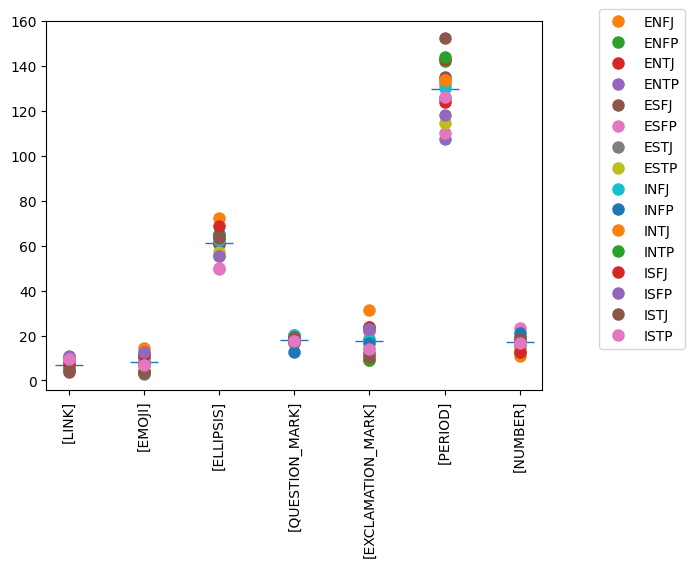

In [529]:
fig, ax = plt.subplots()
(data_train.loc[:, '[LINK]':].sum()/200).plot(ax=ax, style='_', markersize=20, markerfacecolor='black', rot = 30)  #liczność ogólna
(data_train.loc[:, (data_train.columns != 'post_cleaned') & (data_train.columns != 'class_no')].groupby("type").sum()/12.5).transpose().plot(ax=ax, style='o', markersize=8, rot=90)  #liczności typów
ax.legend(bbox_to_anchor=(1.1, 1.05))

Text(-0.9, 6.77, 'mean')

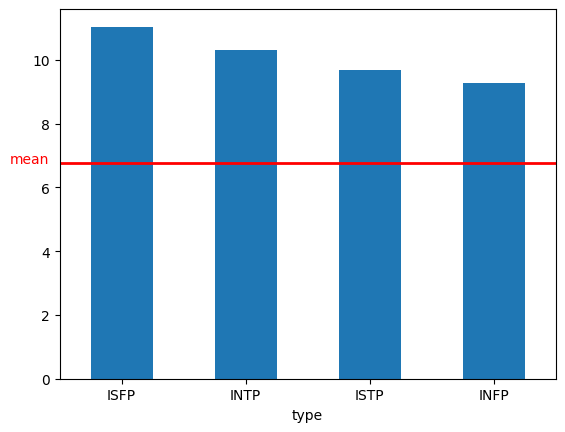

In [530]:
fig, ax = plt.subplots()
p = (data_train.loc[:, (data_train.columns != 'post_cleaned') & (data_train.columns != 'class_no')].groupby("type").sum()/12.5).transpose()
p.loc["[LINK]"].sort_values(ascending=False).head(4).plot(kind='bar', ax=ax, rot=0)
#pd.Series(([data_train.loc[:, '[LINK]'].sum()/200]*10)).plot(ax=ax)
ax.axhline(y=data_train.loc[:, '[LINK]'].sum()/200, color= 'red', linewidth=2,)
ax.text(x= -0.9, y=data_train.loc[:, '[LINK]'].sum()/200, s='mean', c = "red")

In [531]:
#selekcja cech (wagi?)

In [532]:
#box plots?

### Modelowanie

Pomysły: https://monkeylearn.com/text-classification/

- Bag of Words (BoW)
- CNN and RNN

In [533]:
data_train.post_cleaned

0        [agree, people, mentionned, grammar, study, es...
1        [experience, infps, learn, philosophical, doct...
2        [question, esfj, enfj, aux-si, ni, [PERIOD], a...
3        [catherine, intj, maybe, yeah, [PERIOD], hard,...
4        [messing, [PERIOD], agree, intps, well-dispose...
                               ...                        
19995    [think, esfj, fits, best, [ELLIPSIS], still, l...
19996    [profile, pic, esfj, like, well, feminine, bea...
19997    [think, mbti, enough, [PERIOD], use, si, funct...
19998    [esfj, relate, [NUMBER], [PERIOD], sound, like...
19999    [know, enfps, talks, lot, like, esfj, type, fi...
Name: post_cleaned, Length: 20000, dtype: object

Histogramy

(array([1250., 1250., 1250., 1250., 1250., 1250., 1250., 1250., 1250.,
        1250., 1250., 1250., 1250., 1250., 1250., 1250.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <BarContainer object of 16 artists>)

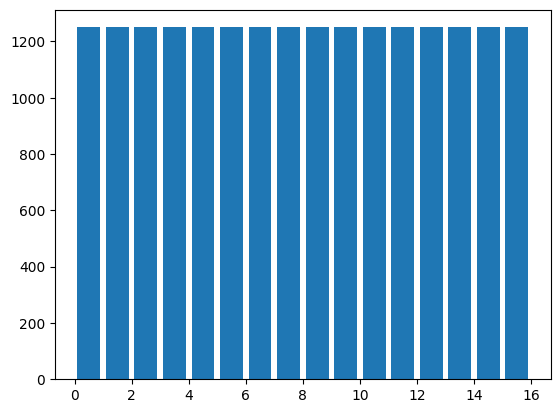

In [534]:
#próbki treningowe
plt.hist(data_train.class_no, bins = list(range(0, 17)), rwidth = 0.8)

(array([250., 250., 250., 250., 250., 250., 250., 250., 250., 250., 250.,
        250., 250., 250., 250., 250.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <BarContainer object of 16 artists>)

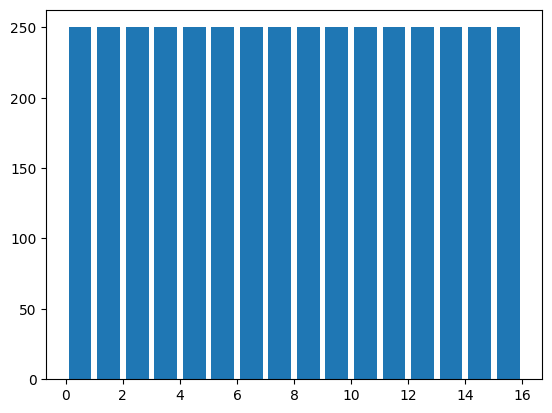

In [535]:
#próbki testowe
plt.hist(data_test.class_no, bins = list(range(0, 17)), rwidth = 0.8)

Mapowanie słów i padding do maksymalnej długości posta

In [536]:
#nowy tokenizer dla czystego i okrojonego tekstu, czysto na potrzeby zamiany postów na sekwencje liczbowe
tokenizer = Tokenizer(num_words=23000)  #obcięte jedynie 60 słów
tokenizer.fit_on_texts(data_train.post_cleaned)  #słownik tworzony na podstawie zbioru treningowego
total_words = len(tokenizer.word_index)
print("Liczba słów:", total_words)

Liczba słów: 23056


In [537]:
tokenizer.word_index    #wygląda prawidłowo

{'[period]': 1,
 '[ellipsis]': 2,
 '[question_mark]': 3,
 '[exclamation_mark]': 4,
 '[number]': 5,
 'like': 6,
 'think': 7,
 'people': 8,
 'know': 9,
 'one': 10,
 '[emoji]': 11,
 'really': 12,
 'would': 13,
 'get': 14,
 '[link]': 15,
 'time': 16,
 'well': 17,
 'say': 18,
 'feel': 19,
 'much': 20,
 'good': 21,
 'things': 22,
 'see': 23,
 'love': 24,
 'want': 25,
 'type': 26,
 'something': 27,
 'also': 28,
 'way': 29,
 'always': 30,
 'lot': 31,
 'even': 32,
 'make': 33,
 'someone': 34,
 'could': 35,
 'actually': 36,
 'though': 37,
 'find': 38,
 'never': 39,
 'go': 40,
 'thing': 41,
 'life': 42,
 'right': 43,
 'sure': 44,
 'first': 45,
 'pretty': 46,
 'going': 47,
 'yes': 48,
 'friends': 49,
 'person': 50,
 'need': 51,
 'friend': 52,
 'lol': 53,
 'best': 54,
 'said': 55,
 'infj': 56,
 'intj': 57,
 'got': 58,
 'many': 59,
 'work': 60,
 'mean': 61,
 'still': 62,
 'probably': 63,
 'maybe': 64,
 'thought': 65,
 'around': 66,
 'thread': 67,
 'read': 68,
 'infp': 69,
 'try': 70,
 'take': 71,
 '

In [538]:
#zamiana tekstu na reprezentację liczbową
data_train['post_tokenized'] = data_train.apply(lambda x: tokenizer.texts_to_sequences([x.post_cleaned])[0], axis=1)

In [539]:
data_train[["post_cleaned", "post_tokenized"]].head()

,post_cleaned,post_tokenized
0,"[agree, people, mentionned, grammar, study, es...","[92, 8, 11165, 1579, 911, 194, 204, 9, 1870, 2..."
1,"[experience, infps, learn, philosophical, doct...","[183, 406, 357, 2225, 11167, 11168, 6195, 1944..."
2,"[question, esfj, enfj, aux-si, ni, [PERIOD], a...","[153, 77, 136, 11169, 212, 1, 30, 6196, 1253, ..."
3,"[catherine, intj, maybe, yeah, [PERIOD], hard,...","[7859, 57, 64, 79, 1, 106, 98, 1, 3980, 79, 17..."
4,"[messing, [PERIOD], agree, intps, well-dispose...","[3051, 1, 92, 358, 11170, 456, 1253, 6, 59, 17..."


In [540]:
max_tokens_len = max(data_train.apply(lambda x: len(x.post_tokenized), axis=1))  #najdłuższy post
max_tokens_len

58

In [541]:
l = data_train.apply(lambda x: len(x.post_tokenized), axis=1).tolist()
l.sort()
np.quantile(l, [0, 0.25, 0.5, 0.75, 0.95, 1])

#95 procent próbek ma długość poniżej 25, dlatego padding do maksymalnej długości (58) wygeneruje wiele zer
#mimo tego warto wypróbować ten prosty schemat

array([ 0.,  8., 17., 20., 24., 58.])

Przemieszanie próbek (żeby te jednego typu nie były w grupie obok siebie)

In [542]:
data_test.head()

,type,class_no,post_cleaned,[LINK],[EMOJI],[ELLIPSIS],[QUESTION_MARK],[EXCLAMATION_MARK],[PERIOD],[NUMBER]
0,INFJ,0,"[enfj, imo, ones, narrowed, [PERIOD], hard, sa...",0,0,1,1,0,4,0
1,INFJ,0,"[ready, 4-1-, [NUMBER], description, [QUESTION...",0,1,0,3,0,0,1
2,INFJ,0,"[thinking, istj, feelings, come, across, awkwa...",0,0,1,0,0,2,0
3,INFJ,0,"[came, thinking, would, say, louise, entj, [PE...",0,1,1,0,0,2,0
4,INFJ,0,"[definitely, legit, [PERIOD], love, author, wo...",0,0,1,0,0,1,1


In [543]:
#przemieszanie bez seeda, ale w obrębie zbioru treningowego osobno, testowego osobno
data_test = data_test.sample(frac = 1)
data_train = data_train.sample(frac = 1)

data_test.head()

,type,class_no,post_cleaned,[LINK],[EMOJI],[ELLIPSIS],[QUESTION_MARK],[EXCLAMATION_MARK],[PERIOD],[NUMBER]
871,INTJ,3,"[wow, [ELLIPSIS], dont, even, know, say, [PERI...",0,0,2,1,0,1,0
2566,ISFJ,10,"[hmm, good, idea, [PERIOD], summer, going, gre...",0,0,0,0,0,3,0
1767,ENFP,7,"[pretty, sure, im, enfp, [EXCLAMATION_MARK], y...",0,0,0,0,1,0,0
1444,ENFJ,5,"[took, enneagram, test, [NUMBER], times, [PERI...",0,0,3,0,0,2,3
1265,ENFJ,5,"[recently, admitted, developing, ed, life, the...",0,0,1,0,0,1,0


In [544]:
#dodać n-gram?

#padding
inputs = pad_sequences(data_train.post_tokenized, maxlen = max_tokens_len, padding = 'pre')   #max_tokens_len-1?
#etykiety
labels = data_train.class_no

inputs.shape, labels.shape

((20000, 58), (20000,))

In [545]:
import tensorflow.keras.utils as ku
labels = ku.to_categorical(labels, 16)

#### Model 1 - Konwolucja

In [405]:
from tensorflow.keras import layers
#from sklearn.metrics import f1_score

inputs = tf.keras.Input(shape=(max_tokens_len, 1))
x = layers.Conv1D(128, 7, activation="relu", strides=3)(inputs)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(16, activation="softmax", name="predictions")(x)

model = tf.keras.Model(inputs, predictions)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 58, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 18, 128)           1024      
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 16)                2064      
                                                             

In [406]:
#tf.convert_to_tensor(data_train.post_tokenized_padded)
#error - array of lists is not acceptable

In [409]:
history = model.fit(inputs, labels, epochs=200, verbose=1)

Epoch 1/200


625/625 [==============================] - 7s 6ms/step - loss: 29.2090 - categorical_accuracy: 0.0616
Epoch 2/200
625/625 [==============================] - 3s 5ms/step - loss: 2.7807 - categorical_accuracy: 0.0595
Epoch 3/200
625/625 [==============================] - 3s 5ms/step - loss: 2.7728 - categorical_accuracy: 0.0556
Epoch 4/200
625/625 [==============================] - 3s 5ms/step - loss: 2.7737 - categorical_accuracy: 0.0560
Epoch 5/200
625/625 [==============================] - 3s 5ms/step - loss: 2.7728 - categorical_accuracy: 0.0596
Epoch 6/200
625/625 [==============================] - 3s 5ms/step - loss: 2.7732 - categorical_accuracy: 0.0584
Epoch 7/200
625/625 [==============================] - 3s 5ms/step - loss: 2.7947 - categorical_accuracy: 0.0576
Epoch 8/200
625/625 [==============================] - 3s 5ms/step - loss: 2.7731 - categorical_accuracy: 0.0600
Epoch 9/200
625/625 [==============================] - 3s 5ms/step - loss: 2.7729 - categorical_accuracy: 0

In [410]:
model.save("model.keras")
loaded_model = tf.keras.models.load_model("model.keras")

In [411]:
#autokeras?

Ewaluacja

https://www.evidentlyai.com/classification-metrics/multi-class-metrics

In [412]:
data_test['post_tokenized'] = data_test.apply(lambda x: tokenizer.texts_to_sequences([x.post_cleaned])[0], axis=1)
test_inputs = pad_sequences(data_test.post_tokenized, maxlen = max_tokens_len, padding = 'pre')
true_labels = data_test.class_no

test_inputs.shape#, true_labels.shape

(4000, 58)

In [413]:
pred_labels = loaded_model.predict(test_inputs)

125/125 [==============================] - 0s 2ms/step


In [414]:
pred_labels

array([[0.06232863, 0.06290098, 0.06251334, ..., 0.06190243, 0.06240455,
        0.06261175],
       [0.06232863, 0.06290098, 0.06251334, ..., 0.06190243, 0.06240455,
        0.06261175],
       [0.06232863, 0.06290098, 0.06251334, ..., 0.06190243, 0.06240455,
        0.06261175],
       ...,
       [0.06232863, 0.06290098, 0.06251334, ..., 0.06190243, 0.06240455,
        0.06261175],
       [0.06232863, 0.06290098, 0.06251334, ..., 0.06190243, 0.06240455,
        0.06261175],
       [0.06232863, 0.06290098, 0.06251334, ..., 0.06190243, 0.06240455,
        0.06261175]], dtype=float32)

In [415]:
np.argmax(pred_labels, axis = 1)   #przypisanie tej samej klasy

array([5, 5, 5, ..., 5, 5, 5], dtype=int64)

In [416]:
pd.DataFrame(np.argmax(pred_labels, axis = 1)).groupby(0).size()

0
0       14
3       13
5     3966
9        1
12       6
dtype: int64

- Zdefiniowanie num_words w Tokenizerze
-----------
- Sigmoid w ostatniej warstwie - model przypisuje identyczne wartości 0 na każdym z 16 neuronów
- Softmax w ostatniej warstwie przypisał takie same prawdopodobieństwa bliskie 1/16 przynależności do każdej klasy każdej próbce, wskazując na klasę 12
-----------
- Zmiana funkcji kosztu z MSE na categorical crossentropy: 3965 labelek tej samej klasy spośród pięciu, które się pojawiły
-----------
- Po przemieszaniu próbek pod względem typów: podobna sytuacja jak powyżej

In [417]:
#za mało próbek (n-gram?)
#za dużo zer (zmniejszyć próbki?)
#znormalizować?

#### Model 2 - Rekurencja

In [269]:
in1 = tf.keras.layers.Input(shape=(max_tokens_len,1))
gru = tf.keras.layers.GRU(512, name='latent_layer')(in1)
bn = tf.keras.layers.BatchNormalization()(gru)
dense = tf.keras.layers.Dense(128, activation="relu")(bn)
drop = tf.keras.layers.Dropout(0.3)(dense)
d1   = tf.keras.layers.Dense(16, activation='softmax')(drop)

model2 = tf.keras.Model(
	inputs=[in1], 
	outputs=[d1]
)

model2.compile(loss="categorical_crossentropy", optimizer="adam")

print(model2.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 58, 1)]           0         
                                                                 
 latent_layer (GRU)          (None, 512)               791040    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 16)                2064      
                                                           

In [270]:
history = model2.fit(inputs, labels, epochs=200, verbose=1)

Epoch 1/200


625/625 [==============================] - 9s 12ms/step - loss: 2.9096
Epoch 2/200
625/625 [==============================] - 7s 11ms/step - loss: 2.7741
Epoch 3/200
625/625 [==============================] - 6s 10ms/step - loss: 2.7667
Epoch 4/200
625/625 [==============================] - 6s 10ms/step - loss: 2.7636
Epoch 5/200
625/625 [==============================] - 6s 10ms/step - loss: 2.7627
Epoch 6/200
625/625 [==============================] - 6s 10ms/step - loss: 2.7610
Epoch 7/200
625/625 [==============================] - 6s 10ms/step - loss: 2.7595
Epoch 8/200
625/625 [==============================] - 6s 10ms/step - loss: 2.7597
Epoch 9/200
625/625 [==============================] - 6s 10ms/step - loss: 2.7606
Epoch 10/200
625/625 [==============================] - 6s 9ms/step - loss: 2.7594
Epoch 11/200
625/625 [==============================] - 6s 10ms/step - loss: 2.7592
Epoch 12/200
625/625 [==============================] - 6s 10ms/step - loss: 2.7575
Epoch 13/200
6

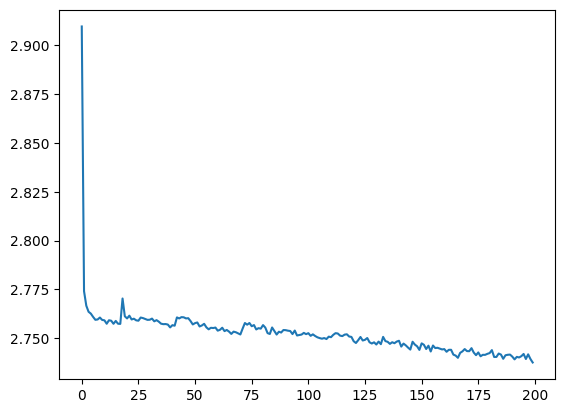

In [271]:
plt.plot(history.history['loss'])

In [402]:
#uwaga - przemieszane tokeny
#model2.save("model2.keras")
loaded_model2 = tf.keras.models.load_model("model2.keras")

In [273]:
pred_labels = loaded_model2.predict(test_inputs)
pred_labels

125/125 [==============================] - 1s 4ms/step


array([[0.02847081, 0.02148518, 0.00926453, ..., 0.21817929, 0.04453756,
        0.06401541],
       [0.05920623, 0.05439896, 0.05017044, ..., 0.05638152, 0.06550919,
        0.08048678],
       [0.04469462, 0.0505168 , 0.07133472, ..., 0.08450379, 0.04741618,
        0.03502015],
       ...,
       [0.06578399, 0.0601481 , 0.06949386, ..., 0.05723241, 0.06470458,
        0.057277  ],
       [0.06525677, 0.07535385, 0.07567964, ..., 0.05265046, 0.06550533,
        0.0561458 ],
       [0.05089586, 0.07011521, 0.07574068, ..., 0.06221157, 0.05706549,
        0.0648362 ]], dtype=float32)

In [274]:
pd.DataFrame(np.argmax(pred_labels, axis = 1)).groupby(0).size()   #przynajmniej rozłożenie między wszystkimi klasami

0
0       18
1      212
2      564
3      260
4       16
5      551
7       65
8      186
9       63
10    1292
11     250
12     129
13     171
14     136
15      87
dtype: int64

In [275]:
((np.argmax(pred_labels, axis = 1) == true_labels).sum())/true_labels.shape[0]  #prawidłowe przypisania (poziom losowy)

0.08

In [403]:
#predykcje na zbiorze treningowym
pred_labels_train = loaded_model2.predict(inputs)
((np.argmax(pred_labels_train, axis = 1) == data_train.class_no).sum())/data_train.class_no.shape[0]  #prawidłowe przypisania (poziom losowy)

625/625 [==============================] - 2s 4ms/step


0.09915

#### Model 3 - Las losowy na tokenach

In [418]:
from sklearn.ensemble import RandomForestClassifier
model3 = RandomForestClassifier()
model3.fit(inputs, labels)

RandomForestClassifier()

In [419]:
#predykcja na danych testowych
pred_labels = model3.predict(test_inputs)

In [420]:
pd.DataFrame(np.argmax(pred_labels, axis = 1)).groupby(0).size()

0
0     3682
1       27
2       20
3       25
4       19
5       17
6       11
7       15
8        8
9       18
10      22
11      34
12      21
13      30
14      24
15      27
dtype: int64

In [421]:
((np.argmax(pred_labels, axis = 1) == true_labels).sum())/true_labels.shape[0] #poziom losowy

0.06125

#### Model 4 - Word2Vec + sieć

**Word2Vec**


https://pyimagesearch.com/2022/07/18/comparison-between-bagofwords-and-word2vec/

https://radimrehurek.com/gensim/models/word2vec.html

parametr vector_size: https://stackoverflow.com/questions/45444964/python-what-is-the-size-parameter-in-gensim-word2vec-model-class

In [422]:
# implementation of Word2Vec using existing solutions
from gensim.models import Word2Vec

# Train a Word2Vec model on the tokenized_sentences dataset
model_vec = Word2Vec(sentences=data_train.post_cleaned, vector_size = 100, window=5, min_count=5, workers=4, epochs=5) #vector_size = 100 

# Save the model to a file
model_vec.save("word2vec_model.model")

# Load the model from a file
model_vec = Word2Vec.load("word2vec_model.model")

#Similar words
model_vec.wv.most_similar("thanks", topn=5)

[('[EMOJI]', 0.9928504228591919),
 ('thank', 0.9922642111778259),
 ('yay', 0.9912117123603821),
 ('welcome', 0.9900633096694946),
 ('oh', 0.9886190295219421)]

In [423]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = model_vec.wv
word_vectors.save("word2vec.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("word2vec.wordvectors", mmap='r')
vector = wv['computer']  # Get numpy vector of a word
print(vector)

[-0.1440552   0.26957992  0.22977698  0.17798589 -0.06928412 -0.6687997
  0.11537655  0.8645906  -0.35598612 -0.17273468 -0.01250186 -0.51271534
 -0.08691902  0.09982519  0.19319627 -0.31169826  0.04208273 -0.39876938
  0.07711107 -0.44979146  0.06889166  0.1178545   0.17500164 -0.16648811
 -0.08317281 -0.1298707  -0.40738642 -0.30208325 -0.48425606  0.04996189
  0.5410107  -0.03385802  0.2336102  -0.32168803 -0.12997682  0.3474824
  0.2378171  -0.31717992 -0.18217787 -0.5138481   0.12892604 -0.3851854
 -0.07462403 -0.09743224  0.32529923 -0.05567877 -0.3111237   0.08508044
  0.09120865  0.27125874  0.10622669 -0.2809163  -0.09327038 -0.02085264
 -0.21162441  0.13610366  0.17947656 -0.23795079 -0.37475616  0.06739338
  0.08989242  0.25755802 -0.16241618 -0.09534198 -0.13071564  0.42959097
  0.08332048  0.17908493 -0.3368654   0.27499187 -0.3965527   0.1040528
  0.4170762  -0.14127988  0.3622945   0.1846702  -0.09483603 -0.06698406
 -0.2090016   0.03978775 -0.07639322  0.06131341 -0.328

In [424]:
len(wv.key_to_index), total_words   #o wiele mniej kluczy niż słów w zbiorze treningowym ->  to generuje błąd niewystępujących kluczy

(5152, 23056)

In [425]:
data_train.post_cleaned[0]

['agree',
 'people',
 'mentionned',
 'grammar',
 'study',
 'especially',
 'already',
 'know',
 'languages',
 'real',
 'time-saver',
 '[PERIOD]',
 'one',
 'favourite',
 'way',
 'picking',
 'new',
 'information',
 '[ELLIPSIS]']

In [426]:
#ERROR
for word in data_train.post_cleaned[0]:
    print(wv[word])

#KeyError: "Key 'mentionned' not present"
#https://stackoverflow.com/questions/72480289/how-to-handle-keyerrorfkey-key-not-present-wor2vec-with-gensim

[-0.14667617  0.01525865  0.12083746  0.3220244  -0.06328294 -0.77908146
  0.07843032  0.81958646 -0.35864288 -0.20122504 -0.14774567 -0.54316497
 -0.04249393  0.23846084  0.23324297 -0.23753701 -0.02663336 -0.44470158
  0.0538604  -0.6555319   0.11894266  0.07201833  0.23584574 -0.2559055
 -0.06039408 -0.16757071 -0.6237763  -0.3127955  -0.47117707  0.06098611
  0.71737576  0.06164609  0.3505672  -0.47684044 -0.22216147  0.35338998
  0.13025995 -0.08366918 -0.1314368  -0.7303316   0.09224409 -0.5087971
 -0.15487134 -0.1748624   0.31098303 -0.08047157 -0.37161714  0.11248088
  0.20525397  0.5067355   0.02580927 -0.35279012 -0.07740194  0.07905596
 -0.14983472  0.2063556   0.22646268 -0.35791948 -0.49347433  0.1910724
  0.0789367   0.33645692 -0.2048449  -0.19877848 -0.23780537  0.5382116
  0.04353185  0.15368517 -0.46481463  0.2800168  -0.31810412  0.25355297
  0.4909219  -0.2728866   0.5160221   0.03312977 -0.02341404 -0.00106224
 -0.1786342   0.02449563 -0.13938162  0.02573006 -0.425

KeyError: "Key 'mentionned' not present"

In [427]:
#przegląd przykładowych słów niewystępujących w zbiorze kluczy - podczas mapowania próbek nie będą uwzględniane
for post in data_train.post_cleaned[0:3]:
    for word in post:
        if word in wv:
            token_vector = wv[word]
            print(word)
        else:
            print(word, "(removed)")
    print("\n")

hmmm
[PERIOD]
seems
intps
quite
humorous
[PERIOD]
exactly
league
esfp
course
everything
tut (removed)
tut (removed)
[PERIOD]
anyway
book
read
found
insightful
[ELLIPSIS]


everything
stresses (removed)
respond
farting (removed)
loudly


oh
gosh
many
[PERIOD]
try
cut
[PERIOD]
[NUMBER]
[PERIOD]
que (removed)
sera (removed)
sera (removed)
[PERIOD]
much
crap
gets
thrown
nothing
eventually
understand
[ELLIPSIS]




In [428]:
vectors = []
for post in data_train.post_cleaned:
    words_vectors = []
    for word in post:
        if word in wv:
            token_vector = wv[word]
            words_vectors.append(token_vector)
        else:
            continue
    vectors.append(np.array(words_vectors))

In [429]:
type(vectors), type(vectors[0]), type(vectors[0][0])   #lista tablic numpy

(list, numpy.ndarray, numpy.ndarray)

In [430]:
vectors[1].shape[0]

3

In [431]:
max_tokens_lenW2V = max([x.shape[0] for x in vectors])   #najdłuższy łańcuch zakodowanych słów (po pominięciu tych nieistniejących w zestawie kluczy Word2Vec)
max_tokens_lenW2V

57

In [432]:
l = [x.shape[0] for x in vectors]
l.sort()
np.quantile(l, [0, 0.25, 0.5, 0.75, 0.95, 1])  #większość łańcuchów zamyka się w 22 słowach

array([ 0.,  7., 15., 19., 22., 57.])

In [433]:
#176 próbek zerowej długości (mamy 1500 postów z każdego typu, więc nie powinna to być duża strata, jeśli zostaną usunięte)
ll = pd.Series(l)
ll[ll==0].count()

176

In [434]:
#"padding" do długości 57
print("Przykładowy rozmiar zakodowanej próbki: ", vectors[0].shape, "\nDocelowy rozmiar:", np.ndarray((max_tokens_lenW2V, 100)).shape)

Przykładowy rozmiar zakodowanej próbki:  (19, 100) 
Docelowy rozmiar: (57, 100)


In [435]:
#sprowadzanie do jednego wymiaru za sprawą "paddingu" zerowego na końcu
max_vec = np.zeros((max_tokens_lenW2V, 100))
max_vec[:vectors[0].shape[0]] = vectors[0]
max_vec

array([[-0.03548112,  0.04817096,  0.07753079, ..., -0.12814011,
         0.01457417,  0.02062183],
       [-0.28034583,  0.30922386,  0.67529643, ..., -0.5198909 ,
         0.14964691,  0.33667818],
       [-0.10026391, -0.18372479,  0.09926609, ..., -0.36722353,
         0.10756423,  0.1746453 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [436]:
data_train.index  #wymieszane indeksy

Index([16472, 15211, 14270,  4911, 17953,  1157, 17340,  2222, 12333, 11451,
       ...
         104,  3730,  2003,  4894, 17439,  9937,   861, 15060, 12324, 13182],
      dtype='int64', length=20000)

In [437]:
empty_samples_idxs = []   #indeksy próbek do usunięcia
vectors_padding = []

for v in range(len(vectors)):
    if vectors[v].shape[0] == 0:
        empty_samples_idxs.append(data_train.index[v])
    else:
        max_vec = np.zeros((max_tokens_lenW2V, 100))
        max_vec[:vectors[v].shape[0]] = vectors[v]
        vectors_padding.append(max_vec)

vectors_padding = np.array(vectors_padding)
vectors_padding.shape

(19824, 57, 100)

In [438]:
#rzeczywiście są to posty zawierające jedynie dziwne wyrazy, których z dużym prawdopodobieństwem Word2Vec nie przyjął do słownika kluczy
print(len(empty_samples_idxs), "\n")
print(data_train.loc[empty_samples_idxs[0]], "\n")
print(data_train.loc[empty_samples_idxs[1]], "\n")
print(data_train.loc[empty_samples_idxs[2]])

176 

type                        ISFP
class_no                       8
post_cleaned          [karethys]
[LINK]                         0
[EMOJI]                        0
[ELLIPSIS]                     0
[QUESTION_MARK]                0
[EXCLAMATION_MARK]             0
[PERIOD]                       0
[NUMBER]                       0
post_tokenized           [17718]
Name: 10103, dtype: object 

type                     ENFP
class_no                    7
post_cleaned          [lames]
[LINK]                      0
[EMOJI]                     0
[ELLIPSIS]                  0
[QUESTION_MARK]             0
[EXCLAMATION_MARK]          0
[PERIOD]                    0
[NUMBER]                    0
post_tokenized        [17087]
Name: 9048, dtype: object 

type                  ISTJ
class_no                11
post_cleaned            []
[LINK]                   0
[EMOJI]                  0
[ELLIPSIS]               0
[QUESTION_MARK]          0
[EXCLAMATION_MARK]       0
[PERIOD]                 0
[

In [439]:
#usuwanie postów bez słów zawartych w zbiorze kluczy Word2Vec
print(len(empty_samples_idxs))
print(data_train.shape)
data_train_W2V = data_train[~data_train.index.isin(empty_samples_idxs)]
print(data_train_W2V.shape)

176
(20000, 11)
(19824, 11)


In [440]:
data_train_W2V.columns

Index(['type', 'class_no', 'post_cleaned', '[LINK]', '[EMOJI]', '[ELLIPSIS]',
       '[QUESTION_MARK]', '[EXCLAMATION_MARK]', '[PERIOD]', '[NUMBER]',
       'post_tokenized'],
      dtype='object')

In [441]:
import keras.utils as ku
inputs_W2V = vectors_padding
labels_W2V = data_train_W2V.class_no
labels_W2V = ku.to_categorical(labels_W2V, 16)

inputs_W2V.shape, labels_W2V.shape

((19824, 57, 100), (19824, 16))

**Architektura A**

In [206]:
#prosty model rekurencyjny

in1 = tf.keras.layers.Input(shape=(inputs_W2V.shape[1], inputs_W2V.shape[2]))
gru = tf.keras.layers.GRU(512, name='latent_layer')(in1)
bn = tf.keras.layers.BatchNormalization()(gru)
dense = tf.keras.layers.Dense(128, activation="relu")(bn)
drop = tf.keras.layers.Dropout(0.3)(dense)
d1   = tf.keras.layers.Dense(16, activation='softmax')(drop)

model4 = tf.keras.Model(
	inputs=[in1], 
	outputs=[d1]
)

model4.compile(loss="categorical_crossentropy", optimizer="adam")

print(model4.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 57, 100)]         0         
                                                                 
 latent_layer (GRU)          (None, 512)               943104    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 16)                2064      
                                                           

In [207]:
history = model4.fit(inputs_W2V, labels_W2V, epochs=100, verbose=1)

Epoch 1/100
620/620 [==============================] - 11s 12ms/step - loss: 2.7756
Epoch 2/100
620/620 [==============================] - 7s 11ms/step - loss: 2.7732
Epoch 3/100
620/620 [==============================] - 7s 12ms/step - loss: 2.7834
Epoch 4/100
620/620 [==============================] - 7s 12ms/step - loss: 2.7700
Epoch 5/100
620/620 [==============================] - 7s 12ms/step - loss: 2.7634
Epoch 6/100
620/620 [==============================] - 7s 12ms/step - loss: 2.7617
Epoch 7/100
620/620 [==============================] - 7s 12ms/step - loss: 2.7588
Epoch 8/100
620/620 [==============================] - 7s 12ms/step - loss: 2.7565
Epoch 9/100
620/620 [==============================] - 7s 12ms/step - loss: 2.7558
Epoch 10/100
620/620 [==============================] - 7s 12ms/step - loss: 2.7546
Epoch 11/100
620/620 [==============================] - 7s 12ms/step - loss: 2.7486
Epoch 12/100
620/620 [==============================] - 7s 11ms/step - loss: 2.7450


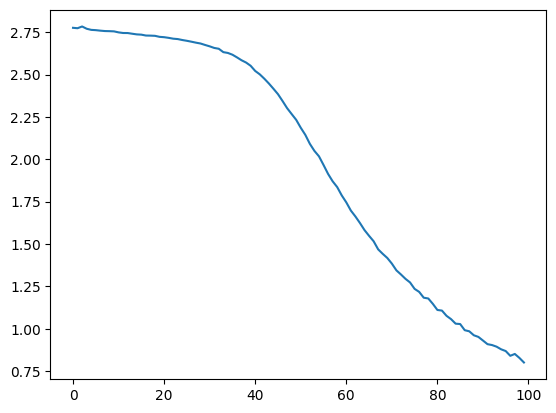

In [208]:
plt.plot(history.history['loss'])

In [209]:
#uwaga - przemieszane tokeny
#model4.save("model4.keras")
loaded_model4 = tf.keras.models.load_model("model4.keras")

In [113]:
#przygotowanie postów testowych

#kodowanie
vectors_test = []
for post in data_test.post_cleaned:
    words_vectors = []
    for word in post:
        if word in wv:
            token_vector = wv[word]
            words_vectors.append(token_vector)
        else:
            continue
    vectors_test.append(np.array(words_vectors))

#padding i wykrywanie indeksów do usunięcia
empty_samples_idxs_test = []   #indeksy próbek do usunięcia
vectors_padding_test = []
for v in range(len(vectors_test)):
    if vectors_test[v].shape[0] == 0:
        empty_samples_idxs_test.append(data_test.index[v])
    else:
        max_vec = np.zeros((max_tokens_lenW2V, 100))
        max_vec[:vectors_test[v].shape[0]] = vectors_test[v]
        vectors_padding_test.append(max_vec)
vectors_padding_test = np.array(vectors_padding_test)
print(vectors_padding_test.shape)

#usuwanie postów bez słów zawartych w zbiorze kluczy Word2Vec
print(len(empty_samples_idxs_test))
print(data_test.shape)
data_test_W2V = data_test[~data_test.index.isin(empty_samples_idxs_test)]
print(data_test_W2V.shape)

import keras.utils as ku
inputs_W2V_test = vectors_padding_test
true_labels_W2V_test = data_test_W2V.class_no

(3982, 57, 100)
18
(4000, 11)
(3982, 11)


In [211]:
pred_labels_W2V = loaded_model4.predict(inputs_W2V_test)

125/125 [==============================] - 1s 7ms/step


In [212]:
pd.DataFrame(np.argmax(pred_labels_W2V, axis = 1)).groupby(0).size()

0
0     276
1     131
2     193
3     134
4     151
5     452
6     380
7     447
8     422
9     248
10    240
11    159
12    146
13    250
14    223
15    130
dtype: int64

In [213]:
((np.argmax(pred_labels_W2V, axis = 1) == true_labels_W2V_test).sum())/true_labels_W2V_test.shape[0]  #prawidłowe przypisania (poziom losowy)

0.06981416373681568

In [217]:
#równe rozłożenie między klasami
#Acc na poziomie losowym

Histogramy

(array([1237., 1244., 1247., 1247., 1248., 1243., 1224., 1232., 1232.,
        1239., 1241., 1236., 1238., 1231., 1244., 1241.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <BarContainer object of 16 artists>)

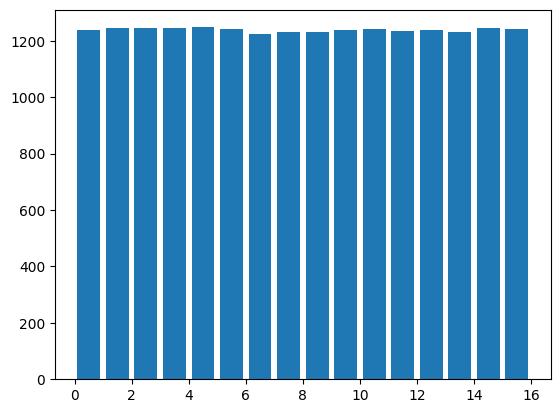

In [442]:
#próbki treningowe
plt.hist(data_train_W2V.class_no, bins = list(range(0, 17)), rwidth = 0.8)

(array([249., 250., 247., 247., 249., 250., 248., 250., 249., 250., 249.,
        248., 249., 249., 248., 250.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16.]),
 <BarContainer object of 16 artists>)

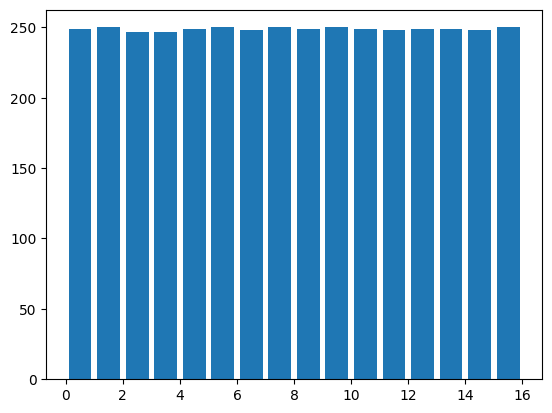

In [443]:
#próbki testowe
plt.hist(data_test_W2V.class_no, bins = list(range(0, 17)), rwidth = 0.8)

Dłuższa próba z Tensorboard

In [444]:
#prosty model rekurencyjny

in1 = tf.keras.layers.Input(shape=(inputs_W2V.shape[1], inputs_W2V.shape[2]))
gru = tf.keras.layers.GRU(512, name='latent_layer')(in1)
bn = tf.keras.layers.BatchNormalization()(gru)
dense = tf.keras.layers.Dense(128, activation="relu")(bn)
drop = tf.keras.layers.Dropout(0.3)(dense)
d1   = tf.keras.layers.Dense(16, activation='softmax')(drop)

model4a = tf.keras.Model(
	inputs=[in1], 
	outputs=[d1]
)

model4a.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.CategoricalAccuracy()])

print(model4a.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 57, 100)]         0         
                                                                 
 latent_layer (GRU)          (None, 512)               943104    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                           

In [108]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model4a.fit(inputs_W2V, labels_W2V, epochs=500, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/500
620/620 [==============================] - 10s 9ms/step - loss: 2.7777 - categorical_accuracy: 0.0625
Epoch 2/500
620/620 [==============================] - 5s 9ms/step - loss: 2.7736 - categorical_accuracy: 0.0594
Epoch 3/500
620/620 [==============================] - 5s 9ms/step - loss: 2.7760 - categorical_accuracy: 0.0617
Epoch 4/500
620/620 [==============================] - 5s 9ms/step - loss: 2.7762 - categorical_accuracy: 0.0609
Epoch 5/500
620/620 [==============================] - 5s 8ms/step - loss: 2.7737 - categorical_accuracy: 0.0596
Epoch 6/500
620/620 [==============================] - 5s 9ms/step - loss: 2.7738 - categorical_accuracy: 0.0589
Epoch 7/500
620/620 [==============================] - 6s 9ms/step - loss: 2.7729 - categorical_accuracy: 0.0617
Epoch 8/500
620/620 [==============================] - 6s 9ms/step - loss: 2.7725 - categorical_accuracy: 0.0596
Epoch 9/500
620/620 [==============================] - 6s 9ms/step - loss: 2.7733 - categorical

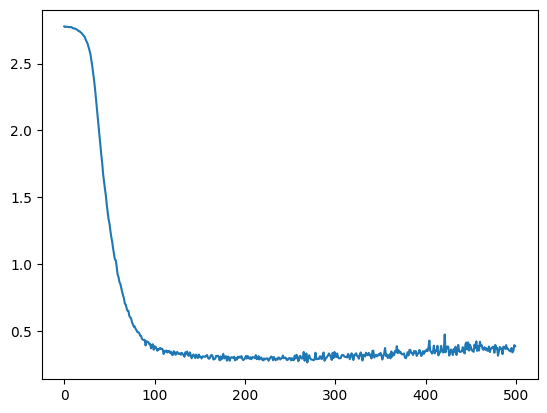

In [109]:
plt.plot(history.history['loss']) #dostępne również w Tensorboard

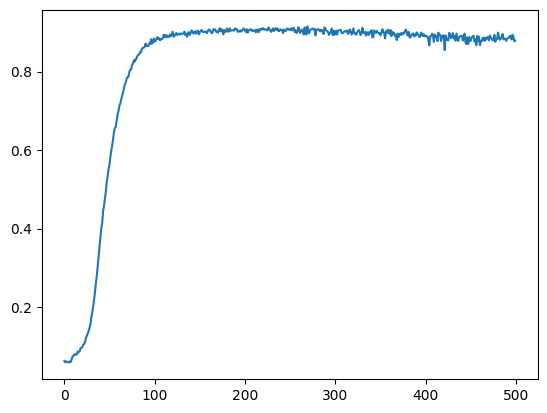

In [115]:
plt.plot(history.history['categorical_accuracy']) #dostępne również w Tensorboard

In [115]:
#uwaga - przemieszane tokeny
#model4a.save("model4a.keras")
loaded_model4a = tf.keras.models.load_model("model4a.keras")

In [134]:
#przygotowanie postów testowych

#kodowanie
vectors_test = []
for post in data_test.post_cleaned:
    words_vectors = []
    for word in post:
        if word in wv:
            token_vector = wv[word]
            words_vectors.append(token_vector)
        else:
            continue
    vectors_test.append(np.array(words_vectors))

#padding i wykrywanie indeksów do usunięcia
empty_samples_idxs_test = []   #indeksy próbek do usunięcia
vectors_padding_test = []
for v in range(len(vectors_test)):
    if vectors_test[v].shape[0] == 0:
        empty_samples_idxs_test.append(data_test.index[v])
    else:
        max_vec = np.zeros((max_tokens_lenW2V, 100))
        max_vec[:vectors_test[v].shape[0]] = vectors_test[v]
        vectors_padding_test.append(max_vec)
vectors_padding_test = np.array(vectors_padding_test)
print(vectors_padding_test.shape)

#usuwanie postów bez słów zawartych w zbiorze kluczy Word2Vec
print(len(empty_samples_idxs_test))
print(data_test.shape)
data_test_W2V = data_test[~data_test.index.isin(empty_samples_idxs_test)]
print(data_test_W2V.shape)

import keras.utils as ku
inputs_W2V_test = vectors_padding_test
true_labels_W2V_test = data_test_W2V.class_no

(3982, 57, 100)
18
(4000, 11)
(3982, 11)


In [117]:
pred_labels_W2V = loaded_model4a.predict(inputs_W2V_test)

125/125 [==============================] - 6s 8ms/step


In [118]:
pd.DataFrame(np.argmax(pred_labels_W2V, axis = 1)).groupby(0).size()

0
0     157
1     647
2      19
3     169
4      78
5     148
6     100
7     368
8     196
9     124
10     41
11    619
12    393
13    240
14    136
15    547
dtype: int64

In [119]:
np.argmax(pred_labels_W2V, axis = 1)

array([11, 12, 15, ...,  8,  3, 11], dtype=int64)

In [120]:
true_labels_W2V_test

2962    11
1973     7
1043     4
405      1
288      1
        ..
1073     4
2449     9
1284     5
1181     4
2060     8
Name: class_no, Length: 3982, dtype: int64

In [121]:
((np.argmax(pred_labels_W2V, axis = 1) == true_labels_W2V_test).sum())/true_labels_W2V_test.shape[0]  #prawidłowe przypisania (poziom losowy)

0.06956303365143145

In [132]:
#porównanie z wbudowaną metryką categorical_accuracy
ku.to_categorical(true_labels_W2V_test).shape, pred_labels_W2V.shape

from keras.metrics import categorical_accuracy
c = categorical_accuracy(ku.to_categorical(true_labels_W2V_test), pred_labels_W2V).numpy()
c.sum()/c.shape[0]

0.06956303365143145

In [142]:
#test na danych treningowych

pred_labels_W2V_train = loaded_model4a.predict(inputs_W2V)

620/620 [==============================] - 3s 5ms/step


In [143]:
pred_labels_W2V_train[0], pred_labels_W2V_train[1], pred_labels_W2V_train[2]

(array([1.7325106e-05, 1.2732109e-02, 3.0761008e-08, 1.1343075e-04,
        1.3405982e-07, 3.8230799e-05, 3.4584116e-06, 9.1500735e-01,
        4.4203753e-05, 4.1372688e-05, 2.1097621e-06, 8.5408235e-04,
        6.4953789e-02, 4.6411104e-05, 1.0681804e-03, 5.0776177e-03],
       dtype=float32),
 array([4.10590974e-06, 2.21220762e-05, 1.18023117e-05, 5.26367476e-05,
        1.48019595e-07, 5.06782555e-04, 2.44321011e-04, 2.61331443e-04,
        8.79491210e-01, 1.97028811e-03, 7.67678066e-05, 2.30206588e-05,
        4.05929723e-06, 1.17262915e-01, 2.31515560e-06, 6.61464364e-05],
       dtype=float32),
 array([4.55540430e-04, 6.87719658e-02, 1.36995863e-03, 4.48947167e-03,
        8.27629212e-03, 3.40993563e-03, 7.55769724e-04, 1.18716685e-02,
        2.06976399e-01, 4.48544655e-04, 1.59840201e-04, 1.98192418e-01,
        3.30513041e-03, 2.86959787e-03, 1.10413402e-03, 4.87543255e-01],
       dtype=float32))

In [144]:
np.argmax(pred_labels_W2V_train, axis = 1) #prawidłowe przypisanie klas na podstawie prawdopodobieństw
#przewidziane klasy

array([ 7,  8, 15, ...,  7, 12,  1], dtype=int64)

In [145]:
data_train_W2V.class_no
#realne klasy

12754    10
11179     8
17254    13
5469      4
2097      1
         ..
17656    14
16817    13
14254    11
18061    14
13901    11
Name: class_no, Length: 19824, dtype: int64

In [146]:
pd.DataFrame(np.argmax(pred_labels_W2V_train, axis = 1)).groupby(0).size()

0
0      928
1     3403
2      112
3      864
4      428
5      659
6      537
7     1993
8      960
9      692
10     203
11    2664
12    2002
13    1242
14     576
15    2561
dtype: int64

In [147]:
#niskie acc na zbiorze treningowym mimo wysokiego categorical acc (na one-hot) podczas treningu
((np.argmax(pred_labels_W2V_train, axis = 1) == data_train_W2V.class_no).sum())/data_train_W2V.class_no.shape[0]

0.1239406779661017

In [148]:
#porównanie z wbudowaną metryką categorical_accuracy
ku.to_categorical(data_train_W2V.class_no).shape, pred_labels_W2V_train.shape

from keras.metrics import categorical_accuracy
c = categorical_accuracy(ku.to_categorical(data_train_W2V.class_no), pred_labels_W2V_train).numpy()
c.sum()/c.shape[0]

0.1239406779661017

**Architektura B**

https://github.com/Alfiuman/Multi-GRU-Classifier/blob/master/Multi_GRU_Classifier.py

In [359]:
#model rekurencyjny

in1 = tf.keras.layers.Input((inputs_W2V.shape[1], inputs_W2V.shape[2]))
gru = tf.keras.layers.GRU(512, name='latent_layer', return_sequences=True)(in1)
bn = tf.keras.layers.BatchNormalization()(gru)
gru2 = tf.keras.layers.GRU(512, name='latent_layer2', return_sequences=True)(gru)
bn2 = tf.keras.layers.BatchNormalization()(gru2)
gru3 = tf.keras.layers.GRU(512, name='latent_layer3')(gru2)
bn3 = tf.keras.layers.BatchNormalization()(gru3)
dense = tf.keras.layers.Dense(128, activation="relu")(bn3)
dense2 = tf.keras.layers.Dense(64, activation="relu")(dense)
drop = tf.keras.layers.Dropout(0.3)(dense2)
d1   = tf.keras.layers.Dense(16, activation='softmax')(drop)

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, GRU, Input

# model4b = Sequential()
# model4b.add(Input((inputs_W2V.shape[1], inputs_W2V.shape[2])))
# model4b.add(GRU(512, return_sequences=True))
# model4b.add(Dropout(0.3))
# model4b.add(GRU(512, return_sequences=True))
# model4b.add(Dropout(0.3))
# model4b.add(GRU(512))
# model4b.add(Dropout(0.3))
# model4b.add(Dense(64, activation='relu'))
# model4b.add(Dropout(0.3))
# model4b.add(Dense(16, activation='softmax'))
# model4b.compile(loss='categorical_crossentropy', optimizer='adam')

model4b = tf.keras.Model(
	inputs=[in1], 
	outputs=[d1]
)

model4b.compile(loss="categorical_crossentropy", optimizer="adam")

print(model4b.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 57, 100)]         0         
                                                                 
 latent_layer (GRU)          (None, 57, 512)           943104    
                                                                 
 latent_layer2 (GRU)         (None, 57, 512)           1575936   
                                                                 
 latent_layer3 (GRU)         (None, 512)               1575936   
                                                                 
 batch_normalization_10 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 128)               65664     
                                                           

Generator 1

In [333]:
from keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(inputs_W2V, labels_W2V, 64)
#test_gen = DataGenerator(X_test, y_test, 32)

In [334]:
inputs_W2V.shape

(19824, 57, 100)

In [335]:
#czy próbki są zbalansowane?
it = train_gen.__iter__()
next(it)[0] == inputs_W2V[:64]
#ten generator odczytuje po kolei paczki próbek zgodnie z ich ułożeniem w pierwotnym zbiorze

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [338]:
a = next(it)[1]
b = next(it)[1]
c = next(it)[1]
d = next(it)[1]

In [339]:
a.sum(axis=0), b.sum(axis=0), c.sum(axis=0), d.sum(axis=0)  #ilość próbek generatora dla każdej z klas nie jest równa

(array([4., 0., 7., 2., 4., 4., 3., 4., 7., 3., 4., 5., 3., 5., 6., 3.],
       dtype=float32),
 array([4., 2., 5., 3., 1., 2., 3., 6., 6., 8., 5., 6., 4., 6., 3., 0.],
       dtype=float32),
 array([8., 3., 2., 4., 6., 6., 4., 4., 3., 3., 3., 3., 4., 2., 3., 6.],
       dtype=float32),
 array([6., 7., 6., 4., 4., 3., 5., 3., 2., 2., 3., 5., 3., 4., 4., 3.],
       dtype=float32))

In [340]:
train_gen[0][0].shape, train_gen[0][1].shape

((64, 57, 100), (64, 16))

Generator 2

In [341]:
#inny generator, twórcy twierdzą, że średnia ilość próbek każdej klasy w batchu jest taka sama
from keras_balanced_batch_generator import make_generator
gen_balanced = make_generator(inputs_W2V, labels_W2V, 64, categorical=True, seed=None)  #rozmiar batcha musi być wielokrotnością 16 (ilości klas)
next(gen_balanced)[0] == inputs_W2V[:64]
#ten generator zachowuje się inaczej niż poprzedni

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [311]:
a = next(gen_balanced)[1]
b = next(gen_balanced)[1]
c = next(gen_balanced)[1]
d = next(gen_balanced)[1]

In [312]:
a.sum(axis=0), b.sum(axis=0), c.sum(axis=0), d.sum(axis=0)  #ilość próbek generatora dla każdej z klas też nie jest równa

(array([5., 6., 2., 3., 3., 2., 5., 3., 4., 5., 1., 2., 3., 5., 9., 6.],
       dtype=float32),
 array([3., 1., 4., 5., 5., 9., 4., 3., 4., 4., 4., 5., 3., 5., 1., 4.],
       dtype=float32),
 array([2., 6., 3., 3., 4., 3., 4., 5., 5., 4., 5., 2., 2., 5., 3., 8.],
       dtype=float32),
 array([5., 5., 3., 3., 3., 5., 6., 2., 2., 5., 2., 6., 1., 3., 9., 4.],
       dtype=float32))

Trening - Generator 1 (batch=32)

In [267]:
#history = model4b.fit(inputs_W2V, labels_W2V, epochs=100, verbose=1)
train_gen = DataGenerator(inputs_W2V, labels_W2V, 32)
history = model4b.fit(train_gen, epochs=100, verbose=1)  #za krótki trening

Epoch 1/100


620/620 [==============================] - 18s 29ms/step - loss: 2.7797
Epoch 2/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7733
Epoch 3/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7729
Epoch 4/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7729
Epoch 5/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7729
Epoch 6/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7729
Epoch 7/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7729
Epoch 8/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7728
Epoch 9/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7729
Epoch 10/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7729
Epoch 11/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7729
Epoch 12/100
620/620 [==============================] - 17s 28ms/step - loss: 2.7729
E

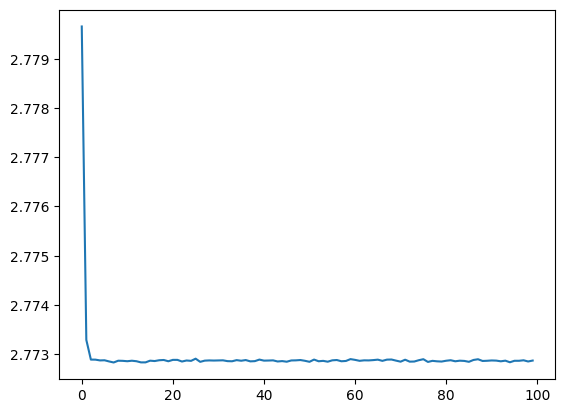

In [268]:
plt.plot(history.history['loss'])

In [269]:
#uwaga - przemieszane tokeny
#model4b.save("model4b.keras")
loaded_model4b = tf.keras.models.load_model("model4b.keras")

In [270]:
pred_labels_W2V = loaded_model4b.predict(inputs_W2V_test)

125/125 [==============================] - 2s 12ms/step


In [271]:
pd.DataFrame(np.argmax(pred_labels_W2V, axis = 1)).groupby(0).size()

0
14    3982
dtype: int64

In [272]:
((np.argmax(pred_labels_W2V, axis = 1) == true_labels_W2V_test).sum())/true_labels_W2V_test.shape[0]  #prawidłowe przypisania (poziom losowy)

0.0622802611752888

Trening - Generator 2 (zbalansowane batche = 64)

In [360]:
#model rekurencyjny

in1 = tf.keras.layers.Input((inputs_W2V.shape[1], inputs_W2V.shape[2]))
gru = tf.keras.layers.GRU(512, name='latent_layer', return_sequences=True)(in1)
bn = tf.keras.layers.BatchNormalization()(gru)
gru2 = tf.keras.layers.GRU(512, name='latent_layer2', return_sequences=True)(gru)
bn2 = tf.keras.layers.BatchNormalization()(gru2)
gru3 = tf.keras.layers.GRU(512, name='latent_layer3')(gru2)
bn3 = tf.keras.layers.BatchNormalization()(gru3)
dense = tf.keras.layers.Dense(128, activation="relu")(bn3)
dense2 = tf.keras.layers.Dense(64, activation="relu")(dense)
drop = tf.keras.layers.Dropout(0.3)(dense2)
d1   = tf.keras.layers.Dense(16, activation='softmax')(drop)

# from keras.models import Sequential
# from keras.layers import Dense, Dropout, GRU, Input

# model4b = Sequential()
# model4b.add(Input((inputs_W2V.shape[1], inputs_W2V.shape[2])))
# model4b.add(GRU(512, return_sequences=True))
# model4b.add(Dropout(0.3))
# model4b.add(GRU(512, return_sequences=True))
# model4b.add(Dropout(0.3))
# model4b.add(GRU(512))
# model4b.add(Dropout(0.3))
# model4b.add(Dense(64, activation='relu'))
# model4b.add(Dropout(0.3))
# model4b.add(Dense(16, activation='softmax'))
# model4b.compile(loss='categorical_crossentropy', optimizer='adam')

model4b = tf.keras.Model(
	inputs=[in1], 
	outputs=[d1]
)

model4b.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.CategoricalAccuracy()])

print(model4b.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 57, 100)]         0         
                                                                 
 latent_layer (GRU)          (None, 57, 512)           943104    
                                                                 
 latent_layer2 (GRU)         (None, 57, 512)           1575936   
                                                                 
 latent_layer3 (GRU)         (None, 512)               1575936   
                                                                 
 batch_normalization_13 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                           

In [361]:
samples_number = inputs_W2V.shape[0]
batch_size = 64

gen_balanced = make_generator(inputs_W2V, labels_W2V, 64, categorical=True, seed=None)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

history = model4b.fit(gen_balanced, epochs=500, steps_per_epoch = int(samples_number/batch_size/100)*100, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/500
300/300 [==============================] - 13s 32ms/step - loss: 2.7821 - categorical_accuracy: 0.0637
Epoch 2/500
300/300 [==============================] - 10s 32ms/step - loss: 2.7733 - categorical_accuracy: 0.0669
Epoch 3/500
300/300 [==============================] - 10s 32ms/step - loss: 2.7690 - categorical_accuracy: 0.0715
Epoch 4/500
300/300 [==============================] - 10s 32ms/step - loss: 2.7666 - categorical_accuracy: 0.0766
Epoch 5/500
300/300 [==============================] - 9s 32ms/step - loss: 2.7646 - categorical_accuracy: 0.0746
Epoch 6/500
300/300 [==============================] - 10s 32ms/step - loss: 2.7628 - categorical_accuracy: 0.0782
Epoch 7/500
300/300 [==============================] - 10s 32ms/step - loss: 2.7615 - categorical_accuracy: 0.0745
Epoch 8/500
300/300 [==============================] - 10s 32ms/step - loss: 2.7601 - categorical_accuracy: 0.0784
Epoch 9/500
300/300 [==============================] - 10s 32ms/step - loss: 2.75

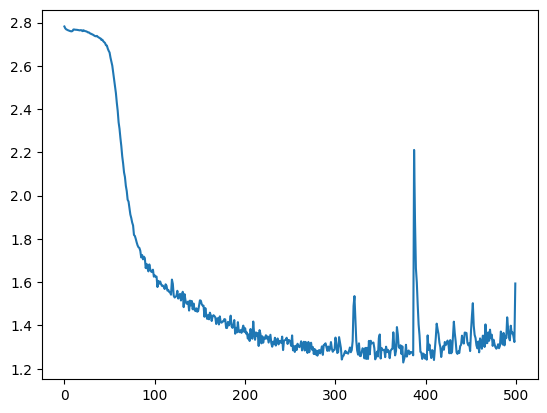

In [362]:
plt.plot(history.history['loss']) #dostępne również w Tensorboard

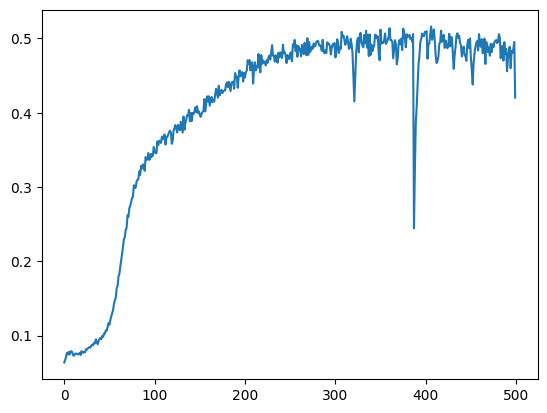

In [363]:
plt.plot(history.history['categorical_accuracy']) #dostępne również w Tensorboard

In [397]:
#uwaga - przemieszane tokeny
#model4b.save("model4b_bal.keras")
loaded_model4b = tf.keras.models.load_model("model4b_bal.keras")

In [365]:
pred_labels_W2V = loaded_model4b.predict(inputs_W2V_test)

125/125 [==============================] - 2s 10ms/step


In [366]:
pd.DataFrame(np.argmax(pred_labels_W2V, axis = 1)).groupby(0).size()

0
1       70
2        4
3     3907
13       1
dtype: int64

In [367]:
((np.argmax(pred_labels_W2V, axis = 1) == true_labels_W2V_test).sum())/true_labels_W2V_test.shape[0]  #prawidłowe przypisania (poziom losowy)

0.06077348066298342

In [400]:
#test na danych treningowych - poziom losowy
pred_labels_W2V_train = loaded_model4b.predict(inputs_W2V)
((np.argmax(pred_labels_W2V_train, axis = 1) == data_train_W2V.class_no).sum())/data_train_W2V.class_no.shape[0]

620/620 [==============================] - 6s 9ms/step


0.06290355125100888

#### Model 5 - Embedding + sieć

In [445]:
inputs, labels #dane wejściowe to tokeny z paddingiem

(array([[    0,     0,     0, ...,   200,  2063,     2],
        [    0,     0,     0, ...,   975, 20439,  3549],
        [    0,     0,     0, ...,   869,    90,     2],
        ...,
        [    0,     0,     0, ...,   233,   398,     2],
        [    0,     0,     0, ...,     1,    30,     2],
        [    0,     0,     0, ...,  1567,  1110,     1]]),
 array([[0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [446]:
#prosty model rekurencyjny

from keras.models import Sequential

model5 = Sequential()
model5.add(tf.keras.layers.Embedding(input_dim = total_words + 1, output_dim = 64, input_length = max_tokens_len))  #+1, bo numeracja tokenów zaczyna się od 1, a nie od 0
model5.add(tf.keras.layers.GRU(512, name='latent_layer'))
model5.add(tf.keras.layers.BatchNormalization())
model5.add(tf.keras.layers.Dense(128, activation="relu"))
model5.add(tf.keras.layers.Dropout(0.3))
model5.add(tf.keras.layers.Dense(16, activation='softmax'))

# model5 = tf.keras.Model(
# 	inputs=[emb], 
# 	outputs=[d1]
# )

model5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.CategoricalAccuracy()])

print(model5.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 58, 64)            1475648   
                                                                 
 latent_layer (GRU)          (None, 512)               887808    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 16)                2064      
                                                      

In [386]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model5.fit(inputs, labels, epochs=200, verbose=1, callbacks=[tensorboard_callback])

Epoch 1/200


625/625 [==============================] - 6s 10ms/step - loss: 2.3277 - categorical_accuracy: 0.2792
Epoch 2/200
625/625 [==============================] - 6s 9ms/step - loss: 1.5236 - categorical_accuracy: 0.5392
Epoch 3/200
625/625 [==============================] - 6s 9ms/step - loss: 0.9611 - categorical_accuracy: 0.7110
Epoch 4/200
625/625 [==============================] - 6s 9ms/step - loss: 0.6847 - categorical_accuracy: 0.7897
Epoch 5/200
625/625 [==============================] - 6s 9ms/step - loss: 0.5553 - categorical_accuracy: 0.8258
Epoch 6/200
625/625 [==============================] - 6s 10ms/step - loss: 0.4877 - categorical_accuracy: 0.8460
Epoch 7/200
625/625 [==============================] - 6s 10ms/step - loss: 0.4461 - categorical_accuracy: 0.8601
Epoch 8/200
625/625 [==============================] - 6s 10ms/step - loss: 0.4118 - categorical_accuracy: 0.8699
Epoch 9/200
625/625 [==============================] - 6s 10ms/step - loss: 0.3851 - categorical_accurac

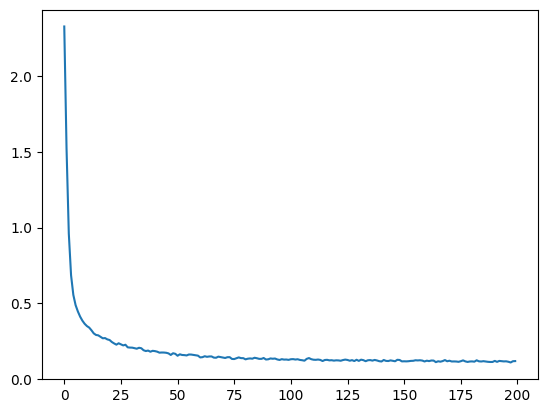

In [387]:
plt.plot(history.history['loss']) #dostępne również w Tensorboard

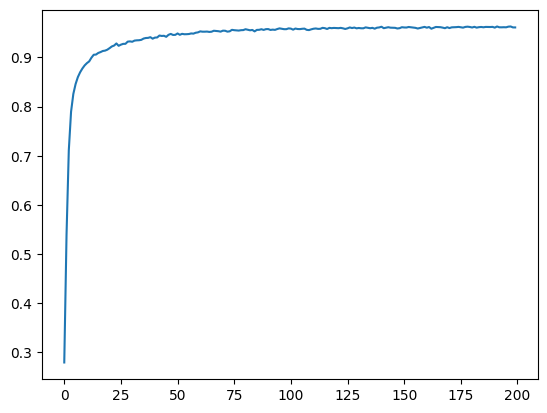

In [388]:
plt.plot(history.history['categorical_accuracy']) #dostępne również w Tensorboard

In [149]:
#uwaga - przemieszane tokeny
#model5.save("model5.keras")
loaded_model5 = tf.keras.models.load_model("model5.keras")

In [160]:
data_test['post_tokenized'] = data_test.apply(lambda x: tokenizer.texts_to_sequences([x.post_cleaned])[0], axis=1)
test_inputs = pad_sequences(data_test.post_tokenized, maxlen = max_tokens_len, padding = 'pre')
true_labels = data_test.class_no

test_inputs.shape, true_labels.shape

((4000, 58), (4000,))

In [161]:
pred_labels_emb = loaded_model5.predict(test_inputs)

  1/125 [..............................] - ETA: 3s

125/125 [==============================] - 1s 7ms/step


In [162]:
pd.DataFrame(np.argmax(pred_labels_emb, axis = 1)).groupby(0).size()

0
0     379
1     139
2     147
3     259
4     188
5     242
6     209
7     178
8     260
9     316
10    311
11    454
12    153
13    233
14    248
15    284
dtype: int64

In [163]:
((np.argmax(pred_labels_emb, axis = 1) == true_labels).sum())/true_labels.shape[0]  #prawidłowe przypisania (poziom losowy)

0.0735

In [164]:
#porównanie z wbudowaną metryką categorical_accuracy
ku.to_categorical(true_labels).shape, pred_labels_emb.shape

from keras.metrics import categorical_accuracy
c = categorical_accuracy(ku.to_categorical(true_labels), pred_labels_emb).numpy()
c.sum()/c.shape[0]

0.0735

In [165]:
#zbiór treningowy
pred_labels_emb_train = loaded_model5.predict(inputs)

  1/625 [..............................] - ETA: 19s

625/625 [==============================] - 3s 5ms/step


In [166]:
pd.DataFrame(np.argmax(pred_labels_emb_train, axis = 1)).groupby(0).size()

0
0     1847
1      840
2      618
3     1227
4     1110
5     1213
6     1142
7      957
8     1272
9     1526
10    1375
11    2060
12     829
13    1112
14    1379
15    1493
dtype: int64

In [167]:
#bardzo wysoki wynik acc dla zbioru treningowego 96% tuż po treningu (przeuczenie), 13-14% po ponownym sprawdzeniu (zestawy próbek train-test się zmieniają z każdym wywołaniem notebooka)

((np.argmax(pred_labels_emb_train, axis = 1) == data_train.class_no).sum())/data_train.class_no.shape[0]  #prawidłowe przypisania (poziom losowy)

0.1334

In [169]:
#porównanie z wbudowaną metryką categorical_accuracy
ku.to_categorical(true_labels).shape, pred_labels_emb_train.shape

from keras.metrics import categorical_accuracy
c = categorical_accuracy(ku.to_categorical(data_train.class_no), pred_labels_emb_train).numpy()
c.sum()/c.shape[0]

0.1334

Sprawdzanie przeuczania - zbiór testowy jako walidacyjny i test własnej metryki dokładności

In [447]:
inputs.shape[0]/625

32.0

In [448]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history = model5.fit(inputs, labels, epochs=100, verbose=2, callbacks=[tensorboard_callback], validation_data=(test_inputs, ku.to_categorical(true_labels)))

Epoch 1/100


625/625 - 10s - loss: 2.7469 - categorical_accuracy: 0.0975 - val_loss: 4.7136 - val_categorical_accuracy: 0.0680 - 10s/epoch - 16ms/step
Epoch 2/100
625/625 - 8s - loss: 2.3887 - categorical_accuracy: 0.2537 - val_loss: 4.4516 - val_categorical_accuracy: 0.0850 - 8s/epoch - 13ms/step
Epoch 3/100
625/625 - 8s - loss: 1.6168 - categorical_accuracy: 0.5073 - val_loss: 9.6378 - val_categorical_accuracy: 0.0675 - 8s/epoch - 13ms/step
Epoch 4/100
625/625 - 8s - loss: 1.0214 - categorical_accuracy: 0.6891 - val_loss: 11.3789 - val_categorical_accuracy: 0.0693 - 8s/epoch - 12ms/step
Epoch 5/100
625/625 - 8s - loss: 0.7127 - categorical_accuracy: 0.7791 - val_loss: 13.1369 - val_categorical_accuracy: 0.0720 - 8s/epoch - 13ms/step
Epoch 6/100
625/625 - 8s - loss: 0.5761 - categorical_accuracy: 0.8199 - val_loss: 12.1537 - val_categorical_accuracy: 0.0787 - 8s/epoch - 12ms/step
Epoch 7/100
625/625 - 7s - loss: 0.4894 - categorical_accuracy: 0.8441 - val_loss: 7.6485 - val_categorical_accuracy: 0

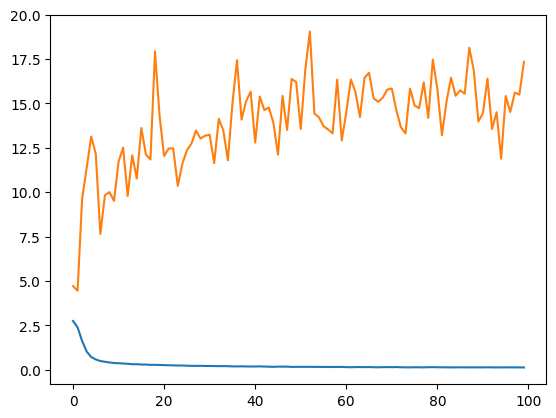

In [449]:
plt.plot(history.history['loss']) #dostępne również w Tensorboard
plt.plot(history.history['val_loss']) #dostępne również w Tensorboard

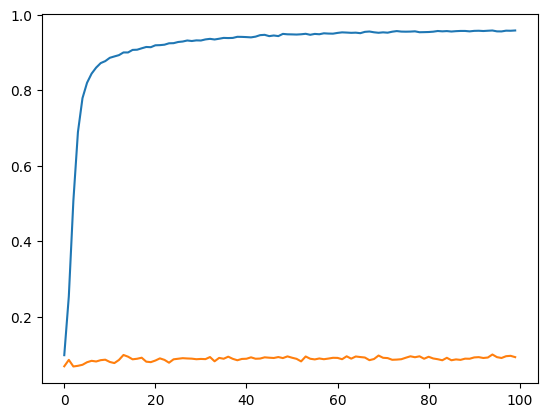

In [450]:
plt.plot(history.history['categorical_accuracy']) #dostępne również w Tensorboard
plt.plot(history.history['val_categorical_accuracy']) #dostępne również w Tensorboard

In [546]:
#model5.save("model5_check.keras")
loaded_model5 = tf.keras.models.load_model("model5_check.keras")

In [452]:
#test na zbiorze testowym
data_test['post_tokenized'] = data_test.apply(lambda x: tokenizer.texts_to_sequences([x.post_cleaned])[0], axis=1)
test_inputs = pad_sequences(data_test.post_tokenized, maxlen = max_tokens_len, padding = 'pre')
true_labels = data_test.class_no

pred_labels_emb = loaded_model5.predict(test_inputs)
pd.DataFrame(np.argmax(pred_labels_emb, axis = 1)).groupby(0).size()

125/125 [==============================] - 1s 5ms/step


0
0      148
1      236
2       38
3      201
4      348
5      157
6      537
7      169
8       34
9      144
10    1031
11     147
12      94
13     306
14     275
15     135
dtype: int64

In [453]:
print(((np.argmax(pred_labels_emb, axis = 1) == true_labels).sum())/true_labels.shape[0])  #prawidłowe przypisania (poziom losowy)

#porównanie z wbudowaną metryką categorical_accuracy
from keras.metrics import categorical_accuracy
c = categorical_accuracy(ku.to_categorical(true_labels), pred_labels_emb).numpy()
print(c.sum()/c.shape[0])

0.09225
0.09225


In [454]:
#test na zbiorze treningowym
pred_labels_emb_train = loaded_model5.predict(inputs)
pd.DataFrame(np.argmax(pred_labels_emb_train, axis = 1)).groupby(0).size()

 28/625 [>.............................] - ETA: 3s

625/625 [==============================] - 3s 5ms/step


0
0     1183
1     1251
2      949
3     1194
4     1272
5     1196
6     1804
7     1191
8      864
9     1181
10    1950
11    1182
12    1144
13    1254
14    1229
15    1156
dtype: int64

In [455]:
#bardzo wysoki wynik acc dla zbioru treningowego 96% tuż po treningu (przeuczenie), 13-14% po ponownym sprawdzeniu (zestawy próbek train-test się zmieniają z każdym wywołaniem notebooka)

print(((np.argmax(pred_labels_emb_train, axis = 1) == data_train.class_no).sum())/data_train.class_no.shape[0])  #prawidłowe przypisania (poziom losowy)

#porównanie z wbudowaną metryką categorical_accuracy
from keras.metrics import categorical_accuracy
c = categorical_accuracy(ku.to_categorical(data_train.class_no), pred_labels_emb_train).numpy()
print(c.sum()/c.shape[0])

0.9195
0.9195


In [547]:
#po ponownym uruchomieniu notebooka i przygotowaniu danych - po przeniesiu komórki przemieszania, wyniki zgadzają się z poprzednim wywołaniem
#test na zbiorze treningowym
pred_labels_emb_train = loaded_model5.predict(inputs)
c = categorical_accuracy(ku.to_categorical(data_train.class_no), pred_labels_emb_train).numpy()
print(c.sum()/c.shape[0])

625/625 [==============================] - 3s 5ms/step
0.9195


In [168]:
#zbalansowane batche
#Word2Vec + las losowy?
#podzielić na 4 klasyfikacje binarne?
#więcej cech
#więcej danych

In [84]:
#lemmatization/stemming function (roots)?
#TF-IGM
#sentiment analysis

#Token count, TF-IDF representation – trace the most frequent words

In [85]:
#PRZYKŁADOWE CECHY
#słownik + histogramy frekwencji słów
#zliczanie linków i emotek
#liczenie długości zdań
#analiza sentymentu
#zliczanie elementów mowy itp.
#obecność liczb, zamiłowanie do używania liczb

In [86]:
#grupowanie wyrazami?